## <font color=#0099CC>mIAx - Taller Renta Fija - ANÁLISIS CARTERA DE RENTA FIJA</font>

En esta práctica, desarrollaremos un análisis relativamente exahustivo de un universo de Renta Fija, en concreto, de bonos corporativos. Además, construiremos y analizaremos varias carteras. 

Para ello, contaremos con la siguiente información almacenada en la carpeta *data*:
- Universo de bonos, con sus características esenciales (fichero *universo.csv*)
- Histórico de precios de cierre del universo de bonos anterior (fichero *precios_historicos_universo.csv*)
- Curva de tipos de interés €STR (fichero *curvaESTR.csv*)
- Histórico de precios de otros índices que nos serán de utilidad (fichero *precios_historicos_varios*):
    - Índices de crédito: ITRAXX Main y ITRAXX XOVER. Serán útiles para la cobertura del riesgo de crédito.
    - Futuros sobre el *Schatz* (DU1), *BOBL* (OE1) y *BUND* (RX1). Serán útiles para la cobertura de los tipos de interés.
    - Índice de crédito *RECMTREU*, que valdría como benchmark de las carteras que construyamos.

No necesariamente se usará toda toda la información

En líneas generales, estos son los ejercicios que completaremos, aunque los detallaremos más en cada apartado:
1. Análisis de datos. En esta sección, haremos un análisis de la información que tenemos de cada bono y lo que significa. Asimismo, haremos los tratamientos y limpieza que necesitemos para luego poder usarlos.
2. Valoración de los bonos del universo utilizando la curva de descuento y bajo ciertas asunciones. Comparación de estos precios con los precios de mercado.
3. Cálculo del spread que pagan los bonos sobre la curva.
4. Cálculo de *yield*, duración y convexidad.
5. Contrucción de una cartera equiponderada con todos los bonos del universo. Contraste con el benchmark (os proponemos el índice RECMTREU para el que os hemos dado los precios) y backtest de la estrategia. ¡OJO! El índice es *Total Return*.
6. Tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
    - La duración de la cartera no debe superar los 3 años
    - La exposición a emisiones HY no puede superar el 10% de la cartera
    - No puedes invertir en deuda subordinada
    - No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
    - No se puede invertir más de un 10% del capital en una misma emisión
    - No puede haber más de un 15% de concentración en un mismo emisor
    (¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

    6.1. Constrúyela a fecha de hoy

    6.2. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

    6.3. ¿Cómo medirías el riesgo de crédito de la cartera? a nivel conceptual

    6.4. ¿Cómo medirías el riesgo de liquidez de la cartera? a nivel conceptual

    6.5. Describe cómo habría que hacer el backtest de esta cartera
7. Ahora, se te pide que cubras la exposición de la cartera a los tipos de interés. Con la información que tienes, ¿cómo lo harías?
conceptual
8. ¿Y si quisieras cubrir total o parcialmente el riesgo de crédito? Usa de nuevo la información que tienes.
conceptual
9. ¿Cómo construirías tu cartera? ¿Se te ocurre alguna estrategia específica, por ejemplo, de valor relativo?


📣 <font color=#CC6600>**¡NORMAS!**</font>

La práctica se puede hacer en grupos de hasta **3 personas** y deberá entregarse antes del **27 de noviembre**. 

Cada grupo expondrá una parte de los ejercicios en la clase del día 27, donde la resolveremos juntos a modo de taller. Esta exposición contará hasta **1 punto** de la nota final.

Además, se valorará positivamente para la práctica la participación en las clases.

📣 <font color=#CC6600>**¡IMPORTANTE!**</font>

Todo el código implementado debe estar debidamente comentado e incluir conclusiones de los resultados obtenidos para optar a la máxima puntuación. Asimismo, se debe responder a las preguntas planteadas.

Las propuestas de mejora o posibles trabajos futuros se valorarán positivamente también.

Usa las fuentes de información que consideres necesarias para apoyar tus respuestas.

### <font color=#336699>Librerías</font>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os
import numpy as np
from dateutil.relativedelta import relativedelta
from datetime import date
from typing import List, Tuple, Optional
from scipy.optimize import brentq
from enum import Enum

In [2]:
# Estilo
plt.style.use('dark_background')

In [3]:
# Fecha de análisis
fecha_analisis = pd.to_datetime('2025-10-01')

### <font color=#336699>1. Datos</font>

<style>.gray {background-color: #595959}

</style><div class="gray">❕💬¿Qué observas en los datos? Analiza la información que tenemos del universo</div>

##### <font color=#CC6600>NOTA MIA: Análisis descriptivo</font>

Haz un primer análisis visual de la información que tenemos del universo de bono.
Entre otras, plantéate cuestiones como:
- ¿Divisas?
- ¿Tipo de bonos? ¿Fijo/Flotante? ¿Prelación? ¿Opcionalidad? ¿Hay bonos perpetuos?
- ¿Sectores? ¿Emisores? Si invirtéramos en todos los bonos, ¿dirías a priori que la cartera está diversificada?
- ¿Ratings? (Riesgo de crédito)
- ¿Otros datos cuantitativos?
    - Riesgo de liquidez - Horquillas y nominal vivo
- ¿Hay *gaps* en la información que vamos a tener que tratar?

In [4]:
# Check current working directory
print("Current working directory:", os.getcwd())

df = pd.read_csv('../data/universo.csv', engine='python', sep=None, encoding='utf-8-sig')

Current working directory: c:\Users\diego\MIAX\02-renta-fija\src


#### <font color=#808080>Divisas</font>

In [5]:
# ver los valores distintos de divisas del daataframe
divisas = df['Ccy'].unique()
print("Divisas en el DataFrame:", divisas)

Divisas en el DataFrame: ['EUR']


#### <font color=#808080>Tipos de bono</font>

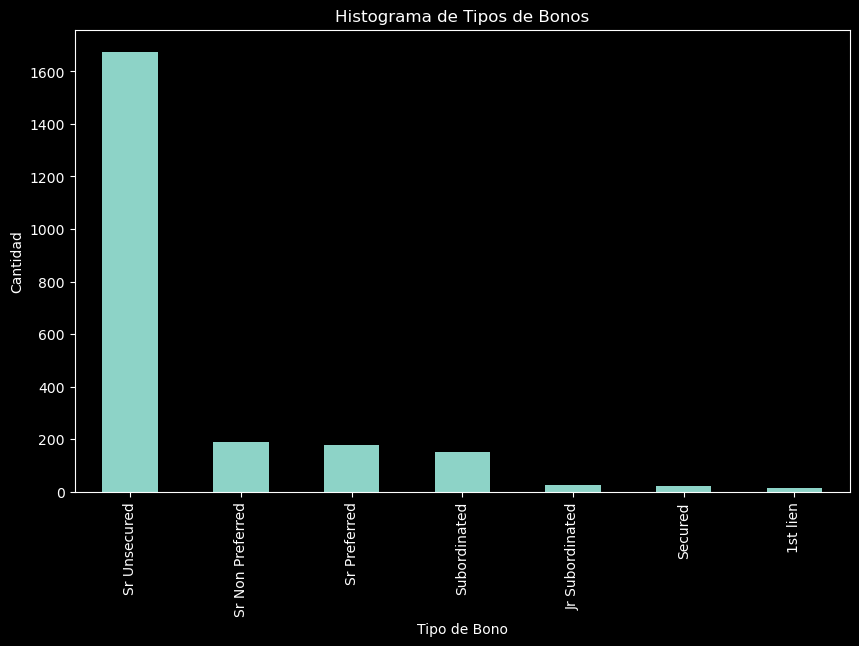

In [6]:
tipo_bono = df['Seniority']
#hisotgrama con conteo de tipos de bonos
plt.figure(figsize=(10,6))
tipo_bono.value_counts().plot(kind='bar')
plt.title('Histograma de Tipos de Bonos')
plt.xlabel('Tipo de Bono')
plt.ylabel('Cantidad')
plt.show()

In [7]:
# contar el numero de cupones por tipo
num_tipo_cupon = df['Coupon Type'].value_counts()
num_tipo_cupon

Coupon Type
FIXED       1910
VARIABLE     345
Name: count, dtype: int64

In [8]:
# Bonos perpetuos donde maturity date es null
bonos_perpetuos = df[df['Maturity'].isnull()]
bonos_perpetuos

,ISIN,Description,Ccy,Price,Issuer,Industry Sector,Maturity,Coupon,Rating,PD 1YR,...,Callable,Next Call Date,Seniority,Coupon Frequency,Coupon Type,First Coupon Date,Penultimate Coupon Date,Issue date,Bid Price,Ask Price
26,XS1115498260,ORAFP 5 PERP,EUR,102.19020,ORANGE SA,Communications,NaN,5.000,BBB-,2.142390e-05,...,Y,01/10/2026,Jr Subordinated,1,VARIABLE,01/10/2015,NaN,01/10/2014,101.894,102.486
54,XS1206541366,VW 3 ½ PERP,EUR,96.28500,VOLKSWAGEN INTL FIN NV,"Consumer, Cyclical",NaN,3.500,BBB-,4.212007e-02,...,Y,20/03/2030,Jr Subordinated,1,VARIABLE,20/03/2016,NaN,20/03/2015,96.012,96.558
120,XS1492580516,SLHNVX 4 ½ PERP,EUR,102.88900,ELM BV (SWISS LIFE),Financial,NaN,4.500,NR,2.039300e-07,...,Y,19/05/2027,Subordinated,1,VARIABLE,19/05/2017,NaN,27/09/2016,102.597,103.182
221,XS1629774230,VW 3 ⅞ PERP,EUR,100.09400,VOLKSWAGEN INTL FIN NV,"Consumer, Cyclical",NaN,3.875,BBB-,4.212007e-02,...,Y,14/06/2027,Jr Subordinated,1,VARIABLE,14/06/2018,NaN,14/06/2017,99.814,100.373
358,XS1799939027,VW 4 ⅝ PERP,EUR,101.62600,VOLKSWAGEN INTL FIN NV,"Consumer, Cyclical",NaN,4.625,BBB-,4.212007e-02,...,Y,27/06/2028,Jr Subordinated,1,VARIABLE,27/06/2019,NaN,27/06/2018,101.345,101.906
577,FR0013447877,ORAFP 1 ¾ PERP,EUR,98.31100,ORANGE SA,Communications,NaN,1.750,BBB-,2.142390e-05,...,Y,19/12/2026,Jr Subordinated,1,VARIABLE,19/03/2020,NaN,19/09/2019,98.043,98.579
596,XS2056730679,IFXGR 3 ⅝ PERP,EUR,100.76870,INFINEON TECHNOLOGIES AG,Technology,NaN,3.625,NR,1.247850e-04,...,Y,01/01/2028,Jr Subordinated,1,VARIABLE,01/04/2020,NaN,01/10/2019,100.475,101.062
850,XS2187689380,VW 3 ⅞ PERP,EUR,98.09600,VOLKSWAGEN INTL FIN NV,"Consumer, Cyclical",NaN,3.875,BBB-,4.212007e-02,...,Y,17/06/2029,Jr Subordinated,1,VARIABLE,17/06/2021,NaN,17/06/2020,97.803,98.389
885,XS2195190520,SSELN 3 ⅛ PERP,EUR,100.05300,SSE PLC,Utilities,NaN,3.125,BBB-,3.055990e-05,...,Y,14/04/2027,Jr Subordinated,1,VARIABLE,14/07/2021,NaN,14/07/2020,99.743,100.363
946,FR00140005L7,ORAFP 1 ¾ PERP,EUR,95.42167,ORANGE SA,Communications,NaN,1.750,BBB-,2.142390e-05,...,Y,15/07/2028,Jr Subordinated,1,VARIABLE,15/10/2021,NaN,15/10/2020,95.093,95.751


#### <font color=#808080>Sectores y emisores</font>

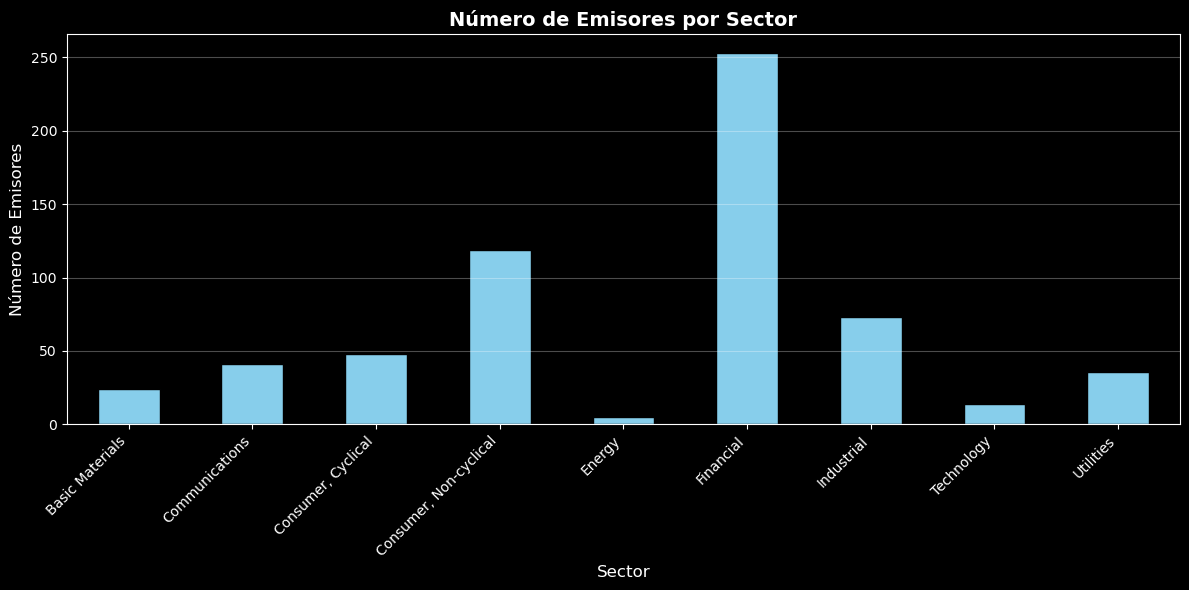


Número de emisores por sector:
Industry Sector
Financial                 253
Consumer, Non-cyclical    119
Industrial                 73
Consumer, Cyclical         48
Communications             41
Utilities                  36
Basic Materials            24
Technology                 14
Energy                      5
Name: Issuer, dtype: int64


In [9]:
sector_emisor = df['Industry Sector']

# Contar el número de emisores únicos por sector
emisores_por_sector = df.groupby('Industry Sector')['Issuer'].nunique()

# Crear el histograma
plt.figure(figsize=(12, 6))
emisores_por_sector.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Número de Emisores por Sector', fontsize=14, fontweight='bold')
plt.xlabel('Sector', fontsize=12)
plt.ylabel('Número de Emisores', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Mostrar también los valores numéricos
print("\nNúmero de emisores por sector:")
print(emisores_por_sector.sort_values(ascending=False))

In [10]:
emisores_frecuencia  = df['Issuer'].value_counts()
print(emisores_frecuencia.sort_values(ascending=False))

Issuer
BANQUE FED CRED MUTUEL      33
BNP PARIBAS                 27
VONOVIA SE                  23
BPCE SA                     23
ORANGE SA                   23
                            ..
ABEILLE VIE SA D'ASSURAN     1
KNORR-BREMSE AG              1
SMITH & NEPHEW PLC           1
EUROCLEAR BANK SA            1
SUDZUCKER INT FINANCE        1
Name: count, Length: 613, dtype: int64


Si invirtéramos en todos los bonos, ¿dirías a priori que la cartera está diversificada?

NO , mucha concentración en mismo emisor y mismo sector

#### <font color=#808080>Ratings (Riesgo de crédito)</font>

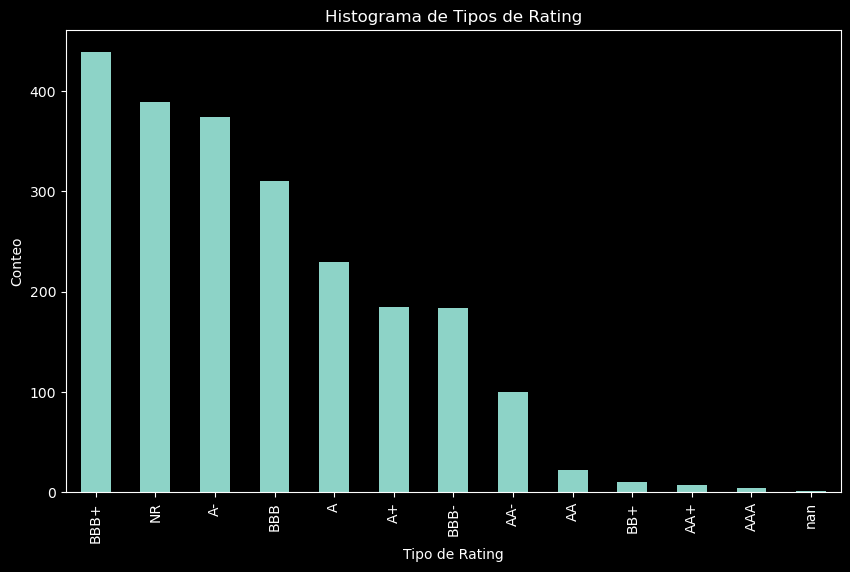

Rating
BBB+    439
NR      389
A-      374
BBB     310
A       230
A+      185
BBB-    184
AA-     100
AA       22
BB+      10
AA+       7
AAA       4
NaN       1
Name: count, dtype: int64


In [11]:
tip_rating = df['Rating']
#hisotgrama con conteo rating
plt.figure(figsize=(10,6))
tip_rating.value_counts(dropna=False).plot(kind='bar')
plt.title('Histograma de Tipos de Rating')
plt.xlabel('Tipo de Rating')
plt.ylabel('Conteo')
plt.show()

print(tip_rating.value_counts(dropna=False).sort_values(ascending=False))

In [12]:
df[df['ISIN'] == 'FI4000496286']

,ISIN,Description,Ccy,Price,Issuer,Industry Sector,Maturity,Coupon,Rating,PD 1YR,...,Callable,Next Call Date,Seniority,Coupon Frequency,Coupon Type,First Coupon Date,Penultimate Coupon Date,Issue date,Bid Price,Ask Price
1106,FI4000496286,NESVFH 0 ¾ 03/25/28,EUR,95.086,NESTE OYJ,Energy,25/03/2028,0.75,NaN,0.000436,...,Y,25/12/2027,Sr Unsecured,1,FIXED,25/03/2022,25/03/2027,25/03/2021,94.994,95.178


#### <font color=#808080>Riesgo de liquidez - Horquillas y nominal vivo</font>

**"La liquidez se ve reflejada en el bid/ask spread"**

In [13]:
df['spread'] = (abs(df['Bid Price'] - df['Ask Price'])).round(4)

In [14]:
df.groupby('Industry Sector')['spread'].mean().sort_values(ascending=False)

Industry Sector
Communications            0.414983
Basic Materials           0.356083
Technology                0.352902
Consumer, Cyclical        0.348029
Energy                    0.343615
Utilities                 0.335380
Industrial                0.326550
Consumer, Non-cyclical    0.322595
Financial                 0.305712
Name: spread, dtype: float64

In [15]:
df.groupby('Rating')['spread'].mean().sort_values(ascending=False)

Rating
AAA     0.424750
BBB-    0.376217
NR      0.345632
BBB     0.333787
BBB+    0.328141
AA-     0.321810
A-      0.314334
A       0.305291
BB+     0.302900
A+      0.292216
AA      0.273545
AA+     0.244857
Name: spread, dtype: float64

**El nominal vivo (outstanding amount) es la cantidad TOTAL emitida y actualmente en circulación en el mercado**



In [16]:
df.groupby('ISIN')[['Outstanding Amount', 'spread']].agg({'Outstanding Amount': 'sum', 'spread': 'mean'}).sort_values(by='Outstanding Amount', ascending=False)

,Outstanding Amount,spread
ISIN,,
CH1214797172,3000000000,0.240
XS2461234622,2500000000,0.210
XS1586555945,2500000000,0.191
XS2595028536,2000000000,0.180
XS1629774230,2000000000,0.559
...,...,...
XS2314267449,300000000,0.592
XS2717378231,300000000,0.456
FR0013321536,274300000,0.461


Qué relación existe entre el spread con el outstanding amount?:

Cuanto mayor es el tamaño de la emisión → más líquida → menor spread bid–ask

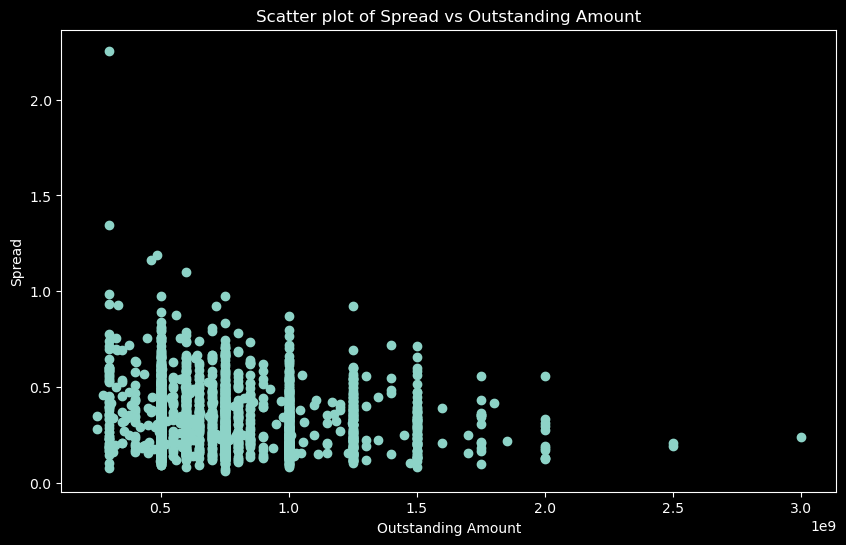

In [17]:
# Scatter plot spread vs outstanding amount
plt.figure(figsize=(10,6))
plt.scatter(df['Outstanding Amount'], df['spread'])
plt.title('Scatter plot of Spread vs Outstanding Amount')
plt.xlabel('Outstanding Amount')
plt.ylabel('Spread')
plt.show()

#### <font color=#808080>Resto de información</font>

En esta sección, analizamos el resto de ficheros para ver qué información tenemos y, en caso de haber *gaps*, limpiar los datos antes de trabajar con ellos.

##### <font color=#CC6600>Precios bonos universo</font>

In [18]:
# Cargar datos de precios históricos del universo
df_precios_universo = pd.read_csv('../data/precios_historicos_universo.csv', engine='python', sep=None)

# Renombrar primera columna a ISIN
df_precios_universo = df_precios_universo.rename(columns={'Unnamed: 0': 'ISIN'})

# Función para normalizar ISIN
def normalizar_isin(isin: str, formato='sin_corp') -> str:
    """Normaliza el formato del ISIN"""
    isin_clean = isin.strip()
    
    if formato == 'sin_corp':
        return isin_clean.replace(' Corp', '')
    elif formato == 'con_corp':
        if not isin_clean.endswith(' Corp'):
            return isin_clean + ' Corp'
    return isin_clean

# Aplicar normalización: remover ' Corp' del ISIN para hacer match con df
df_precios_universo['ISIN'] = df_precios_universo['ISIN'].apply(lambda x: normalizar_isin(x, formato='sin_corp'))

print("Precios históricos del universo cargados y normalizados correctamente")
print(f"Número de bonos: {len(df_precios_universo)}")
print(f"Número de fechas: {len(df_precios_universo.columns) - 1}")  # -1 para excluir columna ISIN
print(f"\nPrimeros ISINs:\n{df_precios_universo['ISIN'].head()}")

Precios históricos del universo cargados y normalizados correctamente
Número de bonos: 2255
Número de fechas: 732

Primeros ISINs:
0    XS0161488498
1    FR0000471930
2    XS0162513211
3    XS0162869076
4    FR0010014845
Name: ISIN, dtype: object


Elimino los fines de semana

In [19]:
# me cargo todas las columnas de precios que son 0 (sin datos)
df_precios_universo = df_precios_universo.loc[:, (df_precios_universo != 0).any(axis=0)]

# Eliminar columnas cuyas fechas corresponden a fines de semana
# Convertir los nombres de las columnas (fechas) a datetime, excluyendo la primera columna que es el ISIN
columnas_fecha = df_precios_universo.columns[1:]  # Excluir la primera columna (ISIN)
fechas_datetime = pd.to_datetime(columnas_fecha, format='%d/%m/%Y', errors='coerce')

# Crear máscara para identificar días que NO son fin de semana (lunes=0, domingo=6)
# weekday: 0-4 son días de semana, 5-6 son sábado y domingo
mascara_dias_semana = fechas_datetime.weekday < 5

# Mantener la primera columna (ISIN) y solo las columnas de días de semana
columnas_mantener = [df_precios_universo.columns[0]] + list(columnas_fecha[mascara_dias_semana])
df_precios_universo = df_precios_universo[columnas_mantener]
df_precios_universo = df_precios_universo.rename(columns={'Unnamed: 0': 'ISIN'})

print(f"Columnas eliminadas (fines de semana): {sum(~mascara_dias_semana)}")
print(f"Columnas restantes: {len(df_precios_universo.columns) - 1}")  # -1 para excluir columna ISIN

Columnas eliminadas (fines de semana): 209
Columnas restantes: 523


Top de los ISINs con mayor número de #N/D

In [20]:
# detectar '#N/D' y sacar los ISIN con mayor cantidad de estos valores
df_n_d_counts = df_precios_universo.set_index('ISIN').map(lambda x: x == '#N/D').sum(axis=1)
df_n_d_counts.sort_values(ascending=False)

ISIN
XS2732952838    61
XS2694995163    58
XS2724401588    57
FR001400MLN4    56
XS2731506841    56
                ..
DE000A3MQQV5     7
XS2101349723     0
XS1562614831     0
XS1511787589     0
ES0211845310     0
Length: 2255, dtype: int64

Cojo el issuance date y reviso el número de #N/d que hay a partir de ahí

In [21]:
# Para cada ISIN, contar #N/D a partir del issue date
def contar_nd_desde_issue_date(row_precios, issue_date_str, columnas_fechas):
    """
    Cuenta las celdas con #N/D en una fila a partir del issue date
    
    Args:
        row_precios: fila del dataframe de precios
        issue_date_str: fecha de emisión en formato string
        columnas_fechas: lista de columnas que son fechas
    
    Returns:
        número de celdas con #N/D desde el issue date
    """
    # Convertir issue date a datetime
    issue_date = pd.to_datetime(issue_date_str, format='%d/%m/%Y', errors='coerce')
    
    if pd.isna(issue_date):
        return None
    
    # Contar #N/D solo en columnas posteriores al issue date
    contador = 0
    for col in columnas_fechas:
        col_date = pd.to_datetime(col, format='%d/%m/%Y', errors='coerce')
        if not pd.isna(col_date) and col_date >= issue_date:
            if row_precios[col] == '#N/D':
                contador += 1
    
    return contador

# Preparar las columnas de fechas (todas excepto la primera que es ISIN)
columnas_fechas = df_precios_universo.columns[1:]

# Crear un diccionario para almacenar los resultados
resultados_nd = {}

# Iterar sobre cada bono del universo
for idx, row_universo in df.iterrows():
    isin = row_universo['ISIN'] + ' Corp'  # Añadir ' Corp' para hacer match con precios
    issue_date = row_universo['Issue date']
    
    # Buscar el ISIN en el dataframe de precios
    if isin in df_precios_universo['ISIN'].values:
        row_precios = df_precios_universo[df_precios_universo['ISIN'] == isin].iloc[0]
        num_nd = contar_nd_desde_issue_date(row_precios, issue_date, columnas_fechas)
        resultados_nd[isin] = num_nd

# Crear un dataframe con los resultados
df_resultados = pd.DataFrame.from_dict(resultados_nd, orient='index', columns=['#N/D desde issue date'])
df_resultados = df_resultados.sort_values(by='#N/D desde issue date', ascending=False)

print(f"Total de bonos analizados: {len(df_resultados)}")
print(f"\nTop 20 bonos con más #N/D desde su issue date:\n")
print(df_resultados.head(20))

Total de bonos analizados: 0

Top 20 bonos con más #N/D desde su issue date:

Empty DataFrame
Columns: [#N/D desde issue date]
Index: []


¿Qué hacemos con estos bonos?

##### <font color=#CC6600>Otros precios</font>

Para terminar con el análisis de datos, falta lo leído en los ficheros de *"precios_historicos_varios.csv"* y *curvaESTR.csv*.

In [22]:
df_precios_varios = pd.read_csv('../data/precios_historicos_varios.csv', engine='python', sep=None)
df_curva = pd.read_csv('../data/curvaESTR.csv', engine='python', sep=None)


Fecha inicial: 10/10/2025
Fecha final: 03/10/2075
Número de puntos: 32
Zero Rate mínimo: 1.9005%
Zero Rate máximo: 2.8694%


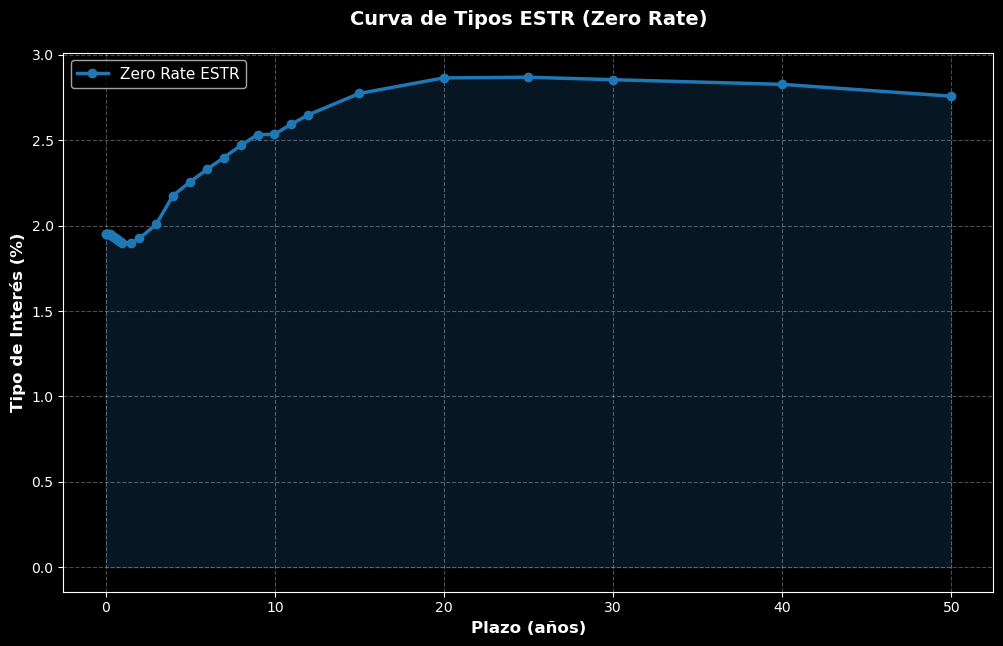

In [23]:
# Convertir la columna de fecha a datetime
df_curva['Date'] = pd.to_datetime(df_curva['Date'], format='%d/%m/%Y')

# Eliminar filas con valores nulos en las tasas
df_curva = df_curva.dropna(subset=['Market Rate', 'Zero Rate'])

# Calcular plazo en años desde la primera fecha
fecha_inicial = df_curva['Date'].iloc[0]
df_curva['Plazo (años)'] = (df_curva['Date'] - fecha_inicial).dt.days / 365.25

# Crear un gráfico adicional más simple y elegante
fig2, ax = plt.subplots(figsize=(12, 7))

ax.plot(df_curva['Plazo (años)'], df_curva['Zero Rate'], marker='o', linewidth=2.5, 
        markersize=6, color='#1f77b4', label='Zero Rate ESTR')
ax.fill_between(df_curva['Plazo (años)'], df_curva['Zero Rate'], alpha=0.2, color='#1f77b4')

ax.set_xlabel('Plazo (años)', fontsize=12, fontweight='bold')
ax.set_ylabel('Tipo de Interés (%)', fontsize=12, fontweight='bold')
ax.set_title('Curva de Tipos ESTR (Zero Rate)', fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linestyle='--')

# Actualizar la leyenda para incluir ambas líneas
ax.legend(fontsize=11)

# Mostrar información adicional
print(f"\nFecha inicial: {fecha_inicial.strftime('%d/%m/%Y')}")
print(f"Fecha final: {df_curva['Date'].iloc[-1].strftime('%d/%m/%Y')}")
print(f"Número de puntos: {len(df_curva)}")
print(f"Zero Rate mínimo: {df_curva['Zero Rate'].min():.4f}%")
print(f"Zero Rate máximo: {df_curva['Zero Rate'].max():.4f}%")

plt.show()

### <font color=#336699>2. Valoración</font>

#### 2.1 Flujos de caja

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 En esta sección, valoraremos los bonos utilizando la curva. Para ello, crea una función (puedes hacerlo en un .py aparte) que con las **características del bono, la curva y un spread de crédito** devuelva la valoración del bono (incluyendo **precio limpio, cupón corrido y precio sucio**).

Si asumimos que el **spread de crédito es 0**, y la ejecutamos para el 01/10/2025...
- ¿Qué observas si comparas los precios obtenidos y los precios de mercado? 
visto en la primera clase
- ¿Crees que la diferencia se debe a un factor relacionado sólo con el riesgo crediticio?
- ¿Qué otros factores influyen en ese spread?

Para la valoración, haz las siguientes simplificaciones:

- Asume que el vencimiento de los bonos perpetuos (para los que no hay vencimiento) es la próxima fecha call.
- Asume que todos aquellos bonos que tengan call serán calleados. Por lo tanto, usa la fecha call como fecha de vencimiento.
- Asume que los cupones son fijos hasta vencimiento (aunque alguno cambie a lo largo de la vida del bono).
- Usa la base de cálculo ACT/365. No tengas en cuenta la convención de día hábil.

Ten en cuenta que necesitarás una función de interpolación también. Interpola los factores de descuento exponencialmente.

</div>

In [24]:
# Establecemos la fecha
fecha_valor = date(2025, 10, 1)

In [25]:
def determinar_fecha_vencimiento(row: pd.Series) -> date:
    """
    Determina la fecha de vencimiento efectiva según las reglas:
    - Si es callable (Callable = 'Y'): usa Next Call Date
    - Si es perpetuo (Maturity vacío/NaN): usa Next Call Date
    - Si no es callable: usa Maturity
    """
    callable = row['Callable']
    maturity = row['Maturity']
    next_call_date = row['Next Call Date']
    
    # Si es callable, usar Next Call Date
    if callable == 'Y':
        return pd.to_datetime(next_call_date).date()
    
    # Si maturity es NaN o está vacío (perpetuo), usar Next Call Date
    if pd.isna(maturity) or maturity == '':
        return pd.to_datetime(next_call_date).date()
    
    # Si no es callable y tiene maturity, usar Maturity
    return pd.to_datetime(maturity).date()

In [26]:
def limpiar_tasa_cupon(cupon_valor) -> float:
    """
    Convierte el cupón de porcentaje a decimal.
    Ej: 5.0 -> 0.05, "5%" -> 0.05
    """
    if pd.isna(cupon_valor):
        return 0.0
    
    cupon_str = str(cupon_valor).strip()
    
    # Remover símbolo de porcentaje si existe
    if '%' in cupon_str:
        cupon_str = cupon_str.replace('%', '')
    
    valor = float(cupon_str)
    
    # Convertir de porcentaje a decimal
    return valor / 100

In [27]:
def calcular_flujos_caja(
    fecha_valoracion: date,
    fecha_vencimiento: date,
    nominal: float,
    tasa_cupon: float,
    frecuencia_pago: int
) -> List[Tuple[date, float]]:
    """
    Calcula los flujos de caja futuros (fecha, monto) de un bono 
    desde la fecha de valoración hasta el vencimiento.
    
    Trabaja hacia atrás desde el vencimiento para generar las fechas de pago.
    
    Args:
        fecha_valoracion: Fecha desde la cual calcular flujos futuros
        fecha_vencimiento: Fecha de vencimiento o call del bono
        nominal: Outstanding Amount del bono
        tasa_cupon: Tasa de cupón anual en decimal (ej: 0.05 para 5%)
        frecuencia_pago: 1 = Anual, 2 = Semestral, 4 = Trimestral, 12 = Mensual
    
    Returns:
        Lista de tuplas (fecha, monto) ordenadas cronológicamente
    """
    
    flujos = []
    
    # Caso especial: Sin cupones (tasa = 0)
    if tasa_cupon == 0:
        # Solo hay un flujo: el nominal al vencimiento
        if fecha_vencimiento > fecha_valoracion:
            flujos.append((fecha_vencimiento, nominal))
        return flujos
    
    # 1. Calcular el monto de cada cupón periódico
    monto_cupon_periodico = (nominal * tasa_cupon) / frecuencia_pago
    
    # 2. Determinar el salto en meses entre pagos
    if frecuencia_pago == 1:
        meses_salto = 12
    elif frecuencia_pago == 2:
        meses_salto = 6
    elif frecuencia_pago == 4:
        meses_salto = 3
    elif frecuencia_pago == 12:
        meses_salto = 1
    else:
        raise ValueError(f"Frecuencia de pago '{frecuencia_pago}' no soportada. Use 1, 2, 4 o 12.")
        
    # 3. Generar flujos trabajando hacia atrás desde el vencimiento
    fecha_flujo = fecha_vencimiento
    
    while fecha_flujo > fecha_valoracion:
        monto_flujo = 0
        
        # 4. Añadir el principal (nominal) en la fecha de vencimiento
        if fecha_flujo == fecha_vencimiento:
            monto_flujo += nominal
        
        # 5. Añadir el cupón periódico
        monto_flujo += monto_cupon_periodico
        
        # Guardamos el flujo
        flujos.append((fecha_flujo, monto_flujo))
        
        # 6. Retrocedemos a la fecha de pago anterior
        fecha_flujo -= relativedelta(months=meses_salto)
        
    # 7. Los flujos se generaron de último a primero. Los ordenamos cronológicamente.
    flujos.reverse()
    
    return flujos


In [28]:
def procesar_bonos(df: pd.DataFrame, fecha_valoracion: date) -> pd.DataFrame:
    """
    Procesa el dataframe completo y calcula los flujos de caja para cada bono.
    
    Args:
        df: DataFrame con los bonos
        fecha_valoracion: Fecha fija de valoración
    
    Returns:
        DataFrame con los resultados incluyendo flujos de caja
    """
    resultados = []
    
    for idx, row in df.iterrows():
        try:
            # Determinar fecha de vencimiento efectiva
            fecha_venc = determinar_fecha_vencimiento(row)
            
            # Obtener parámetros del bono
            nominal = float(row['Outstanding Amount'])
            tasa_cupon = limpiar_tasa_cupon(row['Coupon'])
            frecuencia = int(row['Coupon Frequency'])
            
            # Calcular flujos
            flujos = calcular_flujos_caja(
                fecha_valoracion=fecha_valoracion,
                fecha_vencimiento=fecha_venc,
                nominal=nominal,
                tasa_cupon=tasa_cupon,
                frecuencia_pago=frecuencia
            )
            
            # Calcular valor presente total de los flujos (suma simple)
            valor_total_flujos = sum([monto for _, monto in flujos])
            
            # Guardar resultado
            resultados.append({
                'ISIN': row['ISIN'],
                'Description': row['Description'],
                'Callable': row['Callable'],
                'Maturity': row['Maturity'],
                'Fecha_valoracion': fecha_valoracion,
                'Next_Call_Date': row['Next Call Date'],
                'Fecha_Vencimiento_Efectiva': fecha_venc,
                'Outstanding_Amount': nominal,
                'Coupon_Rate': tasa_cupon,
                'Coupon_Frequency': frecuencia,
                'Numero_Flujos': len(flujos),
                'Flujos_Caja': flujos
            })
            
        except Exception as e:
            print(f"Error procesando ISIN {row['ISIN']}: {str(e)}")
            resultados.append({
                'ISIN': row['ISIN'],
                'Description': row['Description'],
                'Error': str(e)
            })
            continue
    
    return pd.DataFrame(resultados)

In [29]:
# Definir fecha de valoración fija
fecha_valoracion = date(2025, 10, 1)  # Ajusta según necesites

# Procesar todos los bonos
df_flujos = procesar_bonos(df, fecha_valoracion)

df_flujos

C:\Users\diego\AppData\Local\Temp\ipykernel_34600\3967243476.py:21: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(maturity).date()
C:\Users\diego\AppData\Local\Temp\ipykernel_34600\3967243476.py:14: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(next_call_date).date()


,ISIN,Description,Callable,Maturity,Fecha_valoracion,Next_Call_Date,Fecha_Vencimiento_Efectiva,Outstanding_Amount,Coupon_Rate,Coupon_Frequency,Numero_Flujos,Flujos_Caja
0,XS0161488498,DT 7 ½ 01/24/33,N,24/01/2033,2025-10-01,NaN,2033-01-24,5.000000e+08,0.07500,1,8,"[(2026-01-24, 37500000.0), (2027-01-24, 375000..."
1,FR0000471930,ORAFP 8 ⅛ 01/28/33,N,28/01/2033,2025-10-01,NaN,2033-01-28,1.500000e+09,0.08125,1,8,"[(2026-01-28, 121875000.0), (2027-01-28, 12187..."
2,XS0162513211,EOANGR 5 ¾ 02/14/33,N,14/02/2033,2025-10-01,NaN,2033-02-14,6.000000e+08,0.05750,1,8,"[(2026-02-14, 34500000.0), (2027-02-14, 345000..."
3,XS0162869076,TELEFO 5 ⅞ 02/14/33,N,14/02/2033,2025-10-01,NaN,2033-02-14,5.000000e+08,0.05875,1,8,"[(2026-02-14, 29375000.0), (2027-02-14, 293750..."
4,FR0010014845,PEUGOT 6 09/19/33,N,19/09/2033,2025-10-01,NaN,2033-09-19,6.000000e+08,0.06000,1,8,"[(2026-09-19, 36000000.0), (2027-09-19, 360000..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2250,XS2724401588,TVLRO 7 ¼ 12/07/28,Y,07/12/2028,2025-10-01,07/12/2027,2027-07-12,5.000000e+08,0.07250,1,2,"[(2026-07-12, 36250000.0), (2027-07-12, 536250..."
2251,XS2731506841,MET 3 ¾ 12/07/31,N,07/12/2031,2025-10-01,NaN,2031-07-12,5.000000e+08,0.03750,1,6,"[(2026-07-12, 18750000.0), (2027-07-12, 187500..."
2252,FR001400MLN4,URWFP 4 ⅛ 12/11/30,Y,11/12/2030,2025-10-01,11/09/2030,2030-11-09,7.500000e+08,0.04125,1,6,"[(2025-11-09, 30937500.0), (2026-11-09, 309375..."
2253,XS2732952838,SYK 3 ⅜ 12/11/28,Y,11/12/2028,2025-10-01,11/09/2028,2028-11-09,6.000000e+08,0.03375,1,4,"[(2025-11-09, 20250000.0), (2026-11-09, 202500..."


#### 2.2 Cálculo del cupón corrido

In [30]:
def calcular_cupon_corrido(
    fecha_valoracion: date,
    flujos_caja: List[Tuple[date, float]],
    outstanding_amount: float,
    coupon_rate: float,
    frecuencia_pago: int
) -> float:
    """
    Calcula el cupón corrido (accrued interest) de un bono.
    
    Fórmula: Cupón Corrido = (Outstanding Amount × Coupon Rate × Días transcurridos) / 365
    
    Donde:
    - Días transcurridos = días entre fecha valoración y fecha del último cupón pagado
    - Fecha último cupón = primer cupón futuro - período del cupón según frecuencia
    
    Args:
        fecha_valoracion: Fecha de valoración (2025-10-01)
        flujos_caja: Lista de tuplas (fecha, monto) de flujos futuros
        outstanding_amount: Nominal del bono
        coupon_rate: Tasa de cupón anual (en decimal, ej: 0.05 para 5%)
        frecuencia_pago: 1=Anual, 2=Semestral, 4=Trimestral, 12=Mensual
    
    Returns:
        float: Cupón corrido en unidades monetarias
    """
    
    # Caso especial: sin flujos futuros o cupón cero
    if not flujos_caja or coupon_rate == 0:
        return 0.0
    
    # Obtener la fecha del primer cupón futuro
    fecha_primer_cupon_futuro = flujos_caja[0][0]
    
    # Calcular el período del cupón según la frecuencia
    if frecuencia_pago == 1:
        meses_periodo = 12
    elif frecuencia_pago == 2:
        meses_periodo = 6
    elif frecuencia_pago == 4:
        meses_periodo = 3
    elif frecuencia_pago == 12:
        meses_periodo = 1
    else:
        raise ValueError(f"Frecuencia de pago '{frecuencia_pago}' no soportada.")
    
    # Calcular la fecha del último cupón pagado
    # (primer cupón futuro - período del cupón)
    fecha_ultimo_cupon_pagado = fecha_primer_cupon_futuro - relativedelta(months=meses_periodo)
    
    # Validar que la fecha del último cupón sea anterior a la fecha de valoración
    if fecha_ultimo_cupon_pagado >= fecha_valoracion:
        return 0.0
    
    # Calcular días transcurridos desde el último cupón hasta la fecha de valoración
    dias_transcurridos = (fecha_valoracion - fecha_ultimo_cupon_pagado).days
    
    # Calcular cupón corrido usando base ACT/365
    cupon_corrido = (outstanding_amount * coupon_rate * dias_transcurridos) / 365
    
    return cupon_corrido


In [31]:
# Aplicar la función al DataFrame df_flujos para crear la columna Cupon_Corrido
df_flujos['Cupon_Corrido'] = df_flujos.apply(
    lambda row: calcular_cupon_corrido(
        fecha_valoracion=row['Fecha_valoracion'],
        flujos_caja=row['Flujos_Caja'],
        outstanding_amount=row['Outstanding_Amount'],
        coupon_rate=row['Coupon_Rate'],
        frecuencia_pago=row['Coupon_Frequency']
    ),
    axis=1
)
df_flujos

,ISIN,Description,Callable,Maturity,Fecha_valoracion,Next_Call_Date,Fecha_Vencimiento_Efectiva,Outstanding_Amount,Coupon_Rate,Coupon_Frequency,Numero_Flujos,Flujos_Caja,Cupon_Corrido
0,XS0161488498,DT 7 ½ 01/24/33,N,24/01/2033,2025-10-01,NaN,2033-01-24,5.000000e+08,0.07500,1,8,"[(2026-01-24, 37500000.0), (2027-01-24, 375000...",2.568493e+07
1,FR0000471930,ORAFP 8 ⅛ 01/28/33,N,28/01/2033,2025-10-01,NaN,2033-01-28,1.500000e+09,0.08125,1,8,"[(2026-01-28, 121875000.0), (2027-01-28, 12187...",8.214041e+07
2,XS0162513211,EOANGR 5 ¾ 02/14/33,N,14/02/2033,2025-10-01,NaN,2033-02-14,6.000000e+08,0.05750,1,8,"[(2026-02-14, 34500000.0), (2027-02-14, 345000...",2.164521e+07
3,XS0162869076,TELEFO 5 ⅞ 02/14/33,N,14/02/2033,2025-10-01,NaN,2033-02-14,5.000000e+08,0.05875,1,8,"[(2026-02-14, 29375000.0), (2027-02-14, 293750...",1.842979e+07
4,FR0010014845,PEUGOT 6 09/19/33,N,19/09/2033,2025-10-01,NaN,2033-09-19,6.000000e+08,0.06000,1,8,"[(2026-09-19, 36000000.0), (2027-09-19, 360000...",1.183562e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2250,XS2724401588,TVLRO 7 ¼ 12/07/28,Y,07/12/2028,2025-10-01,07/12/2027,2027-07-12,5.000000e+08,0.07250,1,2,"[(2026-07-12, 36250000.0), (2027-07-12, 536250...",8.044521e+06
2251,XS2731506841,MET 3 ¾ 12/07/31,N,07/12/2031,2025-10-01,NaN,2031-07-12,5.000000e+08,0.03750,1,6,"[(2026-07-12, 18750000.0), (2027-07-12, 187500...",4.160959e+06
2252,FR001400MLN4,URWFP 4 ⅛ 12/11/30,Y,11/12/2030,2025-10-01,11/09/2030,2030-11-09,7.500000e+08,0.04125,1,6,"[(2025-11-09, 30937500.0), (2026-11-09, 309375...",2.763185e+07
2253,XS2732952838,SYK 3 ⅜ 12/11/28,Y,11/12/2028,2025-10-01,11/09/2028,2028-11-09,6.000000e+08,0.03375,1,4,"[(2025-11-09, 20250000.0), (2026-11-09, 202500...",1.808630e+07


#### 2.3 Descuento de los flujos

In [32]:
# Cargar la curva ESTR
# Nota: El archivo tiene formato semicolon-separated
df_curva_estr = pd.read_csv('../data/curvaESTR.csv', sep=';')

# Convertir la columna Date a datetime
df_curva_estr['Date'] = pd.to_datetime(df_curva_estr['Date'], format='%d/%m/%Y', errors='coerce')

# Eliminar filas con fechas NaN o valores nulos
df_curva_estr = df_curva_estr.dropna(subset=['Date', 'Discount'])

# Convertir tipos de datos
df_curva_estr['Zero Rate'] = pd.to_numeric(df_curva_estr['Zero Rate'], errors='coerce')
df_curva_estr['Discount'] = pd.to_numeric(df_curva_estr['Discount'], errors='coerce')

# Resetear el índice
df_curva_estr = df_curva_estr.reset_index(drop=True)

print("Curva ESTR cargada correctamente")
print(f"Número de puntos en la curva: {len(df_curva_estr)}")
print("\nPrimeros puntos de la curva:")
print(df_curva_estr.head(10))
print("\nÚltimos puntos de la curva:")
print(df_curva_estr.tail(5))

Curva ESTR cargada correctamente
Número de puntos en la curva: 33

Primeros puntos de la curva:
        Date  Market Rate  Zero Rate  Discount
0 2025-10-01          NaN        NaN  1.000000
1 2025-10-10      1.92700    1.95350  0.999518
2 2025-10-17      1.92800    1.95402  0.999144
3 2025-11-03      1.92800    1.95320  0.998236
4 2025-12-03      1.92900    1.95264  0.996635
5 2026-01-05      1.92710    1.94907  0.994887
6 2026-02-03      1.92745    1.94523  0.993360
7 2026-03-03      1.92210    1.94115  0.991896
8 2026-04-07      1.91720    1.93447  0.990086
9 2026-05-04      1.91180    1.92772  0.988709

Últimos puntos de la curva:
         Date  Market Rate  Zero Rate  Discount
28 2045-10-03      2.80180    2.86536  0.563481
29 2050-10-03      2.81430    2.86943  0.487733
30 2055-10-04      2.81090    2.85489  0.424328
31 2065-10-05      2.80175    2.82775  0.322328
32 2075-10-03      2.76800    2.75841  0.251512


In [33]:
def interpolar_factor_descuento(
    fecha_flujo: date,
    df_curva: pd.DataFrame,
    fecha_valoracion: date
) -> float:
    """
    Interpola el factor de descuento para una fecha dada utilizando interpolación log-lineal.
    
    Si la fecha coincide exactamente con un punto de la curva, retorna el factor de descuento directo.
    Si no, interpola log-linealmente entre los dos puntos más cercanos.
    
    Args:
        fecha_flujo: Fecha del flujo a descontar
        df_curva: DataFrame con la curva ESTR (Date, Discount)
        fecha_valoracion: Fecha de valoración (origen)
    
    Returns:
        float: Factor de descuento para la fecha del flujo
    """
    
    # Convertir fecha_flujo a datetime para comparar
    fecha_flujo_dt = pd.Timestamp(fecha_flujo)
    
    # Buscar coincidencia exacta
    coincidencia = df_curva[df_curva['Date'] == fecha_flujo_dt]
    if not coincidencia.empty:
        return float(coincidencia['Discount'].iloc[0])
    
    # No hay coincidencia exacta: interpolar
    # Encontrar el punto inmediatamente anterior e inmediatamente posterior
    puntos_anteriores = df_curva[df_curva['Date'] < fecha_flujo_dt]
    puntos_posteriores = df_curva[df_curva['Date'] > fecha_flujo_dt]
    
    # Validaciones
    if puntos_anteriores.empty:
        # El flujo es anterior al primer punto de la curva
        # Usar el primer factor de descuento disponible
        return float(df_curva['Discount'].iloc[0])
    
    if puntos_posteriores.empty:
        # El flujo es posterior al último punto de la curva
        # Extrapolar usando el último punto
        return float(df_curva['Discount'].iloc[-1])
    
    # Obtener los dos puntos para interpolar
    punto_1 = puntos_anteriores.iloc[-1]  # Punto más cercano anterior
    punto_2 = puntos_posteriores.iloc[0]  # Punto más cercano posterior
    
    # Extraer fechas y factores de descuento
    t1 = punto_1['Date']
    t2 = punto_2['Date']
    df1 = float(punto_1['Discount'])
    df2 = float(punto_2['Discount'])
    
    # Calcular plazos en años (base ACT/365)
    T1 = (t1 - pd.Timestamp(fecha_valoracion)).days / 365.0
    T2 = (t2 - pd.Timestamp(fecha_valoracion)).days / 365.0
    T_flujo = (fecha_flujo_dt - pd.Timestamp(fecha_valoracion)).days / 365.0
    
    # Interpolación log-lineal de factores de descuento:
    # ln(DF(T)) = ln(DF(T1)) + (ln(DF(T2)) - ln(DF(T1))) * (T - T1) / (T2 - T1)
    
    log_df1 = np.log(df1)
    log_df2 = np.log(df2)
    
    log_df_flujo = log_df1 + (log_df2 - log_df1) * (T_flujo - T1) / (T2 - T1)
    
    df_flujo = np.exp(log_df_flujo)
    
    return df_flujo

In [34]:
class MetodoDescuento(Enum):
    """Métodos de descuento disponibles"""
    CURVA = "curva"  # Usando curva de tipos + spread
    YIELD = "yield"   # Usando yield único constante


def calcular_valor_presente(
    flujos_caja,  # List[Tuple[date, float]] o List[Tuple[float, float]]
    fecha_valoracion: Optional[date] = None,
    metodo: MetodoDescuento = MetodoDescuento.YIELD,
    # Parámetros para método CURVA
    df_curva: Optional[pd.DataFrame] = None,
    spread_credito: float = 0.0,
    # Parámetros para método YIELD
    yield_anual: Optional[float] = None,
    frecuencia: int = 2,
    # Formato de flujos
    flujos_como_fechas: bool = True
) -> float:
    """
    Calcula el valor presente de flujos de caja usando diferentes métodos de descuento.
    
    Args:
        flujos_caja: Lista de tuplas (fecha, monto) si flujos_como_fechas=True
                     o (tiempo_años, monto) si flujos_como_fechas=False
        fecha_valoracion: Fecha de valoración (requerido si flujos_como_fechas=True)
        metodo: Método de descuento (CURVA o YIELD)
        
        # Para método CURVA (valoración mark-to-market):
        df_curva: DataFrame con la curva ESTR (columnas: 'Date', 'Discount')
        spread_credito: Spread de crédito en decimal (ej: 0.01 para 100 bps)
        
        # Para método YIELD (cálculo de YTM):
        yield_anual: Yield anual en decimal (ej: 0.03 para 3%)
        frecuencia: Frecuencia de capitalización (1=anual, 2=semestral, 4=trimestral)
        
        # Formato de flujos:
        flujos_como_fechas: Si True, flujos_caja contiene (fecha, monto)
                           Si False, flujos_caja contiene (tiempo_años, monto)
    
    Returns:
        float: Valor presente de los flujos
        
    Raises:
        ValueError: Si faltan parámetros requeridos según el método elegido
        
    Examples:
        >>> # Valoración con curva de mercado
        >>> vp = calcular_valor_presente(
        ...     flujos, fecha_val, MetodoDescuento.CURVA,
        ...     df_curva=curva_estr, spread_credito=0.01
        ... )
        
        >>> # Valoración con yield único (flujos como fechas)
        >>> vp = calcular_valor_presente(
        ...     flujos, fecha_val, MetodoDescuento.YIELD,
        ...     yield_anual=0.03, frecuencia=2
        ... )
        
        >>> # Valoración con yield único (flujos como tiempos)
        >>> vp = calcular_valor_presente(
        ...     flujos_tiempo, metodo=MetodoDescuento.YIELD,
        ...     yield_anual=0.03, frecuencia=2, flujos_como_fechas=False
        ... )
    """
    
    if metodo == MetodoDescuento.CURVA:
        # ============ MÉTODO CURVA ============
        if df_curva is None:
            raise ValueError("Se requiere 'df_curva' para el método CURVA")
        if not flujos_como_fechas:
            raise ValueError("El método CURVA requiere flujos_como_fechas=True")
        if fecha_valoracion is None:
            raise ValueError("Se requiere 'fecha_valoracion' para el método CURVA")
        
        valor_presente = 0.0
        
        for fecha_flujo, monto_flujo in flujos_caja:
            # Obtener factor de descuento de la curva (interpolado si es necesario)
            df_curva_flujo = interpolar_factor_descuento(
                fecha_flujo, df_curva, fecha_valoracion
            )
            
            # Calcular plazo en años (ACT/365)
            plazo_anos = (fecha_flujo - fecha_valoracion).days / 365.0
            
            # Aplicar spread de crédito con capitalización continua
            # DF_ajustado = DF_curva × exp(-spread × T)
            factor_descuento_ajustado = df_curva_flujo * np.exp(-spread_credito * plazo_anos)
            
            # Descontar el flujo
            valor_presente += monto_flujo * factor_descuento_ajustado
        
        return valor_presente
    
    elif metodo == MetodoDescuento.YIELD:
        # ============ MÉTODO YIELD ============
        if yield_anual is None:
            raise ValueError("Se requiere 'yield_anual' para el método YIELD")
        
        valor_presente = 0.0
        
        if flujos_como_fechas:
            # Flujos en formato (fecha, monto)
            if fecha_valoracion is None:
                raise ValueError("Se requiere 'fecha_valoracion' cuando flujos_como_fechas=True")
            
            for fecha_flujo, monto_flujo in flujos_caja:
                # Calcular tiempo en años (ACT/365)
                tiempo_anos = (fecha_flujo - fecha_valoracion).days / 365.0
                
                # Descuento con composición periódica
                # DF = 1 / (1 + y/freq)^(t × freq)
                factor_descuento = (1 + yield_anual / frecuencia) ** (tiempo_anos * frecuencia)
                valor_presente += monto_flujo / factor_descuento
        else:
            # Flujos en formato (tiempo_años, monto)
            for tiempo_anos, monto_flujo in flujos_caja:
                # Descuento con composición periódica
                # DF = 1 / (1 + y/freq)^(t × freq)
                factor_descuento = (1 + yield_anual / frecuencia) ** (tiempo_anos * frecuencia)
                valor_presente += monto_flujo / factor_descuento
        
        return valor_presente
    
    else:
        raise ValueError(f"Método de descuento no reconocido: {metodo}")

In [35]:
def descontar_flujos(
    flujos_caja: List[Tuple[date, float]],
    df_curva: pd.DataFrame,
    fecha_valoracion: date,
    spread_credito: float = 0.0
) -> float:
    """
    Descuenta los flujos de caja utilizando la curva ESTR y un spread de crédito opcional.
    
    NOTA: Esta función es un wrapper de calcular_valor_presente() para mantener
    compatibilidad con código existente. Para nuevos desarrollos, usar directamente
    calcular_valor_presente() con MetodoDescuento.CURVA.
    
    Utiliza capitalización continua:
    Precio = Σ [Flujo_i × DF(T_i) × exp(-spread × T_i)]
    
    Args:
        flujos_caja: Lista de tuplas (fecha, monto)
        df_curva: DataFrame con la curva ESTR
        fecha_valoracion: Fecha de valoración
        spread_credito: Spread de crédito en decimal (ej: 0.01 para 100 bps)
    
    Returns:
        float: Valor presente de los flujos (precio sucio)
    """
    return calcular_valor_presente(
        flujos_caja=flujos_caja,
        fecha_valoracion=fecha_valoracion,
        metodo=MetodoDescuento.CURVA,
        df_curva=df_curva,
        spread_credito=spread_credito
    )

In [36]:
# Calcular precio sucio (valor presente de todos los flujos)
df_flujos['Precio_Sucio'] = df_flujos.apply(
    lambda row: descontar_flujos(
        flujos_caja=row['Flujos_Caja'],
        df_curva=df_curva_estr,
        fecha_valoracion=row['Fecha_valoracion'],
        spread_credito=0.0  # Spread de crédito = 0 por ahora
    ),
    axis=1
)

# Calcular precio limpio (precio sucio - cupón corrido)
df_flujos['Precio_Limpio'] = df_flujos['Precio_Sucio'] - df_flujos['Cupon_Corrido']

# Convertir a precio por unidad de nominal (100 = par)
df_flujos['Precio_Limpio_Pct'] = (df_flujos['Precio_Limpio'] / df_flujos['Outstanding_Amount']) * 100
df_flujos['Precio_Sucio_Pct'] = (df_flujos['Precio_Sucio'] / df_flujos['Outstanding_Amount']) * 100

In [37]:
df_flujos

,ISIN,Description,Callable,Maturity,Fecha_valoracion,Next_Call_Date,Fecha_Vencimiento_Efectiva,Outstanding_Amount,Coupon_Rate,Coupon_Frequency,Numero_Flujos,Flujos_Caja,Cupon_Corrido,Precio_Sucio,Precio_Limpio,Precio_Limpio_Pct,Precio_Sucio_Pct
0,XS0161488498,DT 7 ½ 01/24/33,N,24/01/2033,2025-10-01,NaN,2033-01-24,5.000000e+08,0.07500,1,8,"[(2026-01-24, 37500000.0), (2027-01-24, 375000...",2.568493e+07,6.944742e+08,6.687892e+08,133.757847,138.894833
1,FR0000471930,ORAFP 8 ⅛ 01/28/33,N,28/01/2033,2025-10-01,NaN,2033-01-28,1.500000e+09,0.08125,1,8,"[(2026-01-28, 121875000.0), (2027-01-28, 12187...",8.214041e+07,2.151706e+09,2.069565e+09,137.971025,143.447053
2,XS0162513211,EOANGR 5 ¾ 02/14/33,N,14/02/2033,2025-10-01,NaN,2033-02-14,6.000000e+08,0.05750,1,8,"[(2026-02-14, 34500000.0), (2027-02-14, 345000...",2.164521e+07,7.549505e+08,7.333053e+08,122.217546,125.825080
3,XS0162869076,TELEFO 5 ⅞ 02/14/33,N,14/02/2033,2025-10-01,NaN,2033-02-14,5.000000e+08,0.05875,1,8,"[(2026-02-14, 29375000.0), (2027-02-14, 293750...",1.842979e+07,6.337144e+08,6.152846e+08,123.056925,126.742884
4,FR0010014845,PEUGOT 6 09/19/33,N,19/09/2033,2025-10-01,NaN,2033-09-19,6.000000e+08,0.06000,1,8,"[(2026-09-19, 36000000.0), (2027-09-19, 360000...",1.183562e+06,7.533621e+08,7.521785e+08,125.363091,125.560351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2250,XS2724401588,TVLRO 7 ¼ 12/07/28,Y,07/12/2028,2025-10-01,07/12/2027,2027-07-12,5.000000e+08,0.07250,1,2,"[(2026-07-12, 36250000.0), (2027-07-12, 536250...",8.044521e+06,5.540081e+08,5.459636e+08,109.192721,110.801625
2251,XS2731506841,MET 3 ¾ 12/07/31,N,07/12/2031,2025-10-01,NaN,2031-07-12,5.000000e+08,0.03750,1,6,"[(2026-07-12, 18750000.0), (2027-07-12, 187500...",4.160959e+06,5.422481e+08,5.380871e+08,107.617422,108.449613
2252,FR001400MLN4,URWFP 4 ⅛ 12/11/30,Y,11/12/2030,2025-10-01,11/09/2030,2030-11-09,7.500000e+08,0.04125,1,6,"[(2025-11-09, 30937500.0), (2026-11-09, 309375...",2.763185e+07,8.438013e+08,8.161695e+08,108.822598,112.506845
2253,XS2732952838,SYK 3 ⅜ 12/11/28,Y,11/12/2028,2025-10-01,11/09/2028,2028-11-09,6.000000e+08,0.03375,1,4,"[(2025-11-09, 20250000.0), (2026-11-09, 202500...",1.808630e+07,6.417910e+08,6.237047e+08,103.950776,106.965159


### <font color=#336699>3. Spread</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora los spreads que debemos añadir a la curva con un movimiento paralelo para que cuadren los precios de mercado que tenemos. Para ello, usa la función de valoración del apartado anterior. 

Z SPREAD
- ¿Qué observas? ¿Tienen sentido los resultados? 
- ¿Con qué datos de los que tenemos compararías para ver si los resultados son coherentes?

</div>

#### 3.1 Brent

In [38]:
# ------------------------------------------------------------
# Función para calcular Z-Spread con el método de Brent
# ------------------------------------------------------------
def calcular_z_spread(
    precio_mercado_limpio: float,
    flujos_caja: List[Tuple[date, float]],
    cupon_corrido: float,
    df_curva: pd.DataFrame,
    fecha_valoracion: date,
    outstanding_amount: float
) -> float:
    """
    Calcula el Z-spread de un bono usando el método de Brent.
    """

    if not flujos_caja or outstanding_amount == 0:
        return np.nan

    precio_mercado_limpio_abs = (precio_mercado_limpio / 100.0) * outstanding_amount
    precio_mercado_sucio = precio_mercado_limpio_abs + cupon_corrido

    # Definir función raíz: VP(spread) - PrecioMercadoSucio = 0
    def funcion_raiz(spread):
        vp = descontar_flujos(
            flujos_caja=flujos_caja,
            df_curva=df_curva,
            fecha_valoracion=fecha_valoracion,
            spread_credito=spread
        )
        return vp - precio_mercado_sucio

    try:
        f_a = funcion_raiz(-0.05)
        f_b = funcion_raiz(0.20)

        # Verificar que exista cambio de signo
        if f_a * f_b > 0:
            return np.nan

        # Ejecutar método de Brent
        resultado = brentq(funcion_raiz, -0.05, 0.20, xtol=1e-10, rtol=1e-8, maxiter=100, full_output=False)
        spread_opt = float(resultado)
        return spread_opt * 10000  # convertir a bps

    except Exception as e:
        print(f"Error en cálculo de Z-spread: {e}")
        return np.nan


In [39]:
print("Calculando Z-spread para todos los bonos...")
print("Esto puede tardar algunos minutos debido a la optimización numérica...\n")

# Obtener precios de mercado del DataFrame base
precio_mercado_dict = dict(zip(df['ISIN'], df['Price']))

# Añadir precio de mercado al DataFrame de flujos
df_flujos['Precio_Mercado'] = df_flujos['ISIN'].map(precio_mercado_dict)

# Calcular Z-Spread para cada bono
df_flujos['Z_Spread_bps'] = df_flujos.apply(
    lambda row: calcular_z_spread(
        precio_mercado_limpio=row['Precio_Mercado'],
        flujos_caja=row['Flujos_Caja'],
        cupon_corrido=row['Cupon_Corrido'],
        df_curva=df_curva_estr,
        fecha_valoracion=row['Fecha_valoracion'],
        outstanding_amount=row['Outstanding_Amount']
    ) if not pd.isna(row['Precio_Mercado']) else np.nan,
    axis=1
)

print("✅ Cálculo de Z-spread completado.\n")

Calculando Z-spread para todos los bonos...
Esto puede tardar algunos minutos debido a la optimización numérica...

✅ Cálculo de Z-spread completado.



In [40]:
def calcular_precio_con_spread(row):
    if pd.isna(row['Z_Spread_bps']):
        return np.nan

    precio_sucio = descontar_flujos(
        flujos_caja=row['Flujos_Caja'],
        df_curva=df_curva_estr,
        fecha_valoracion=row['Fecha_valoracion'],
        spread_credito=row['Z_Spread_bps'] / 10000
    )
    precio_limpio = precio_sucio - row['Cupon_Corrido']
    return (precio_limpio / row['Outstanding_Amount']) * 100

df_flujos['Precio_con_ZSpread'] = df_flujos.apply(calcular_precio_con_spread, axis=1)
df_flujos['Diferencia_Precio'] = df_flujos['Precio_con_ZSpread'] - df_flujos['Precio_Mercado']

In [41]:
df_flujos

,ISIN,Description,Callable,Maturity,Fecha_valoracion,Next_Call_Date,Fecha_Vencimiento_Efectiva,Outstanding_Amount,Coupon_Rate,Coupon_Frequency,...,Flujos_Caja,Cupon_Corrido,Precio_Sucio,Precio_Limpio,Precio_Limpio_Pct,Precio_Sucio_Pct,Precio_Mercado,Z_Spread_bps,Precio_con_ZSpread,Diferencia_Precio
0,XS0161488498,DT 7 ½ 01/24/33,N,24/01/2033,2025-10-01,NaN,2033-01-24,5.000000e+08,0.07500,1,...,"[(2026-01-24, 37500000.0), (2027-01-24, 375000...",2.568493e+07,6.944742e+08,6.687892e+08,133.757847,138.894833,127.8353,74.378485,127.8353,1.136868e-13
1,FR0000471930,ORAFP 8 ⅛ 01/28/33,N,28/01/2033,2025-10-01,NaN,2033-01-28,1.500000e+09,0.08125,1,...,"[(2026-01-28, 121875000.0), (2027-01-28, 12187...",8.214041e+07,2.151706e+09,2.069565e+09,137.971025,143.447053,131.3195,81.904379,131.3195,1.136868e-13
2,XS0162513211,EOANGR 5 ¾ 02/14/33,N,14/02/2033,2025-10-01,NaN,2033-02-14,6.000000e+08,0.05750,1,...,"[(2026-02-14, 34500000.0), (2027-02-14, 345000...",2.164521e+07,7.549505e+08,7.333053e+08,122.217546,125.825080,115.7800,85.550665,115.7800,3.268497e-13
3,XS0162869076,TELEFO 5 ⅞ 02/14/33,N,14/02/2033,2025-10-01,NaN,2033-02-14,5.000000e+08,0.05875,1,...,"[(2026-02-14, 29375000.0), (2027-02-14, 293750...",1.842979e+07,6.337144e+08,6.152846e+08,123.056925,126.742884,116.3000,89.516733,116.3000,3.410605e-13
4,FR0010014845,PEUGOT 6 09/19/33,N,19/09/2033,2025-10-01,NaN,2033-09-19,6.000000e+08,0.06000,1,...,"[(2026-09-19, 36000000.0), (2027-09-19, 360000...",1.183562e+06,7.533621e+08,7.521785e+08,125.363091,125.560351,112.3887,163.401057,112.3887,1.509193e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2250,XS2724401588,TVLRO 7 ¼ 12/07/28,Y,07/12/2028,2025-10-01,07/12/2027,2027-07-12,5.000000e+08,0.07250,1,...,"[(2026-07-12, 36250000.0), (2027-07-12, 536250...",8.044521e+06,5.540081e+08,5.459636e+08,109.192721,110.801625,107.8130,73.131647,107.8130,-1.421085e-14
2251,XS2731506841,MET 3 ¾ 12/07/31,N,07/12/2031,2025-10-01,NaN,2031-07-12,5.000000e+08,0.03750,1,...,"[(2026-07-12, 18750000.0), (2027-07-12, 187500...",4.160959e+06,5.422481e+08,5.380871e+08,107.617422,108.449613,103.2010,78.781850,103.2010,0.000000e+00
2252,FR001400MLN4,URWFP 4 ⅛ 12/11/30,Y,11/12/2030,2025-10-01,11/09/2030,2030-11-09,7.500000e+08,0.04125,1,...,"[(2025-11-09, 30937500.0), (2026-11-09, 309375...",2.763185e+07,8.438013e+08,8.161695e+08,108.822598,112.506845,104.4336,87.123256,104.4336,3.084054e-09
2253,XS2732952838,SYK 3 ⅜ 12/11/28,Y,11/12/2028,2025-10-01,11/09/2028,2028-11-09,6.000000e+08,0.03375,1,...,"[(2025-11-09, 20250000.0), (2026-11-09, 202500...",1.808630e+07,6.417910e+08,6.237047e+08,103.950776,106.965159,102.2970,53.330505,102.2970,-1.881517e-11


### <font color=#336699>4. YTM, Duración, Convexidad</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora la siguiente información, también relacionada con la rentabilidad y riesgo de las emisiones:
- *Yield* - Por simplicidad, en este caso, en el caso de los bonos callable, nos quedaremos con la fecha call, como en el ejercicio anterior. Usa las mismas asunciones que para la valoración y el spread.
- Duración
- Convexidad

Responde a las siguientes preguntas:
- ¿Que relación hay entre la TIR calculada y el spread calculado en el apartado anterior?
- ¿Qué relación hay entre la duración y el vencimiento? ¿Qué refleja la duración? ¿De qué otra forma se podría obtener esta sensibilidad?
- Estima el precio del bono usando la duración y convexidad, ¿qué observas?

</div>

#### 4.1 Yield

In [42]:
def calcular_yield(precio_sucio_mercado, flujos, frecuencia=2, guess=0.03):
    """
    Calcula el Yield to Maturity (YTM) de un bono a partir del precio de mercado.
    
    El YTM es la tasa interna de retorno (TIR) que iguala el valor presente 
    de todos los flujos de caja futuros con el precio de mercado del bono.
    
    Args:
        precio_sucio_mercado (float): Precio objetivo (Dirty Price) del bono en el mercado.
                                       Puede ser en términos absolutos o como % del nominal.
        flujos (list): Lista de tuplas [(tiempo_en_años, monto)] con los flujos de caja del bono.
                      - tiempo_en_años: Tiempo hasta el flujo en años (fracción de año)
                      - monto: Cantidad del flujo de caja
        frecuencia (int): Frecuencia de composición anual. Por defecto 2 (semestral).
                         Usualmente coincide con la frecuencia de pago de cupones.
        guess (float): Estimación inicial del yield como tasa anual (ej: 0.03 = 3%).
    
    Returns:
        float: Yield to Maturity como tasa anual (ej: 0.0325 = 3.25%)
               o np.nan si no se encuentra solución.
    
    Ejemplo:
        >>> flujos = [(0.5, 2.5), (1.0, 2.5), (1.5, 2.5), (2.0, 102.5)]
        >>> precio = 100.0
        >>> ytm = calcular_yield(precio, flujos, frecuencia=2)
        >>> print(f"YTM: {ytm*100:.4f}%")
    """
    from scipy.optimize import brentq
    import numpy as np
    
    # Validación de inputs
    if not flujos or len(flujos) == 0:
        return np.nan
    
    if precio_sucio_mercado <= 0:
        return np.nan
    
    def valor_presente_flujos(yield_anual):
        """
        Calcula el valor presente de todos los flujos dado un yield.
        
        NOTA: Utiliza la función unificada calcular_valor_presente() 
        con método YIELD y formato de flujos como tiempo en años.
        """
        return calcular_valor_presente(
            flujos_caja=flujos,
            metodo=MetodoDescuento.YIELD,
            yield_anual=yield_anual,
            frecuencia=frecuencia,
            flujos_como_fechas=False
        )
    
    def diferencia_precio(yield_anual):
        """
        Función objetivo: diferencia entre el VP de flujos y el precio de mercado.
        Buscamos el yield que haga esta diferencia = 0
        """
        return valor_presente_flujos(yield_anual) - precio_sucio_mercado
    
    try:
        # Determinar rango de búsqueda basado en la estimación inicial
        # Amplio rango: desde -2% hasta +50% anual
        lower_bound = -0.02
        upper_bound = 0.50
        
        # Verificar que hay un cambio de signo en el rango
        diff_lower = diferencia_precio(lower_bound)
        diff_upper = diferencia_precio(upper_bound)
        
        if diff_lower * diff_upper > 0:
            # No hay cambio de signo, intentar con rango más amplio
            if diff_lower > 0:  # Precio muy bajo, necesitamos yields más altos
                upper_bound = 1.0
            else:  # Precio muy alto, necesitamos yields más bajos (incluso negativos)
                lower_bound = -0.10
            
            diff_lower = diferencia_precio(lower_bound)
            diff_upper = diferencia_precio(upper_bound)
            
            if diff_lower * diff_upper > 0:
                # Aún no hay solución en el rango
                return np.nan
        
        # Usar el método de Brent para encontrar la raíz
        ytm = brentq(
            diferencia_precio,
            lower_bound,
            upper_bound,
            xtol=1e-10,      # Tolerancia absoluta
            rtol=1e-8,       # Tolerancia relativa
            maxiter=100      # Máximo de iteraciones
        )
        
        return ytm
        
    except Exception as e:
        print(f"Error en cálculo de YTM: {e}")
        return np.nan

In [43]:
def convertir_flujos_a_tiempo(flujos_caja, fecha_valoracion):
    """Convierte flujos de caja (fecha, monto) a (tiempo_años, monto)"""
    flujos_tiempo = []
    for fecha_flujo, monto in flujos_caja:
        tiempo_anos = (fecha_flujo - fecha_valoracion).days / 365.0
        flujos_tiempo.append((tiempo_anos, monto))
    return flujos_tiempo


def calcular_ytm_bono(row):
    """
    Calcula YTM de un bono usando el precio de mercado.
    
    CORRECCIÓN CRÍTICA: Usa el precio sucio de MERCADO,
    no el precio teórico calculado con la curva.
    """
    if pd.isna(row['Precio_Mercado']):
        return np.nan
    
    # Convertir flujos a formato de tiempo
    flujos_tiempo = convertir_flujos_a_tiempo(
        row['Flujos_Caja'], 
        row['Fecha_valoracion']
    )
    
    # ✅ CORRECCIÓN: Calcular precio sucio de MERCADO
    # Precio de mercado (limpio) + cupón corrido = precio sucio de mercado
    precio_sucio_mercado = (
        (row['Precio_Mercado'] / 100) * row['Outstanding_Amount'] 
        + row['Cupon_Corrido']
    )
    
    # Calcular YTM
    ytm = calcular_yield(
        precio_sucio_mercado=precio_sucio_mercado,
        flujos=flujos_tiempo,
        frecuencia=int(row['Coupon_Frequency']),
        guess=0.03
    )
    
    return ytm


# Aplicar el cálculo de YTM a todo el DataFrame
print("Calculando YTM para todos los bonos usando precio de mercado...")
df_flujos['YTM'] = df_flujos.apply(calcular_ytm_bono, axis=1)
df_flujos['YTM_pct'] = df_flujos['YTM'] * 100

print("✅ Cálculo de YTM completado correctamente.\n")

# Verificación: Mostrar bonos con YTM calculado
bonos_con_ytm = df_flujos[~df_flujos['YTM'].isna()]
print(f"Bonos con YTM calculado: {len(bonos_con_ytm)}/{len(df_flujos)}")
print("\nEstadísticas de YTM:")
print(df_flujos['YTM_pct'].describe())

Calculando YTM para todos los bonos usando precio de mercado...
✅ Cálculo de YTM completado correctamente.

Bonos con YTM calculado: 2255/2255

Estadísticas de YTM:
count    2255.000000
mean        2.971563
std         0.589327
min        -3.643356
25%         2.600060
50%         2.922721
75%         3.262674
max         8.847468
Name: YTM_pct, dtype: float64


#### 4.2 Duración

In [44]:
def calcular_duraciones(
    flujos_caja: list,
    fecha_valoracion: date,
    df_curva: pd.DataFrame,
    ytm: float = None,
    precio_limpio: float = None
) -> tuple:
    """
    Calcula la Duración de Macaulay y Duración Modificada de un bono.

    Parámetros:
        flujos_caja: Lista de tuplas (fecha, monto) con los flujos futuros
        fecha_valoracion: Fecha de valoración
        df_curva: DataFrame con la curva ESTR (columnas: 'Date', 'Discount')
        ytm: Yield to Maturity (opcional). Si no se proporciona, se usa aproximación 3%
        precio_limpio: Precio limpio del bono (opcional, se calcula si no se proporciona)

    Retorna:
        tuple: (duracion_macaulay, duracion_modificada, precio_limpio)
    """
    if not flujos_caja:
        return None, None, None

    # Si no se proporciona el precio limpio, calcularlo usando la función existente
    if precio_limpio is None:
        precio_limpio = calcular_valor_presente(
            flujos_caja=flujos_caja,
            fecha_valoracion=fecha_valoracion,
            metodo=MetodoDescuento.CURVA,
            df_curva=df_curva,
            spread_credito=0.0,
            flujos_como_fechas=True
        )

    if precio_limpio == 0:
        return None, None, None

    # Calcular la suma ponderada por tiempo para la duración de Macaulay
    suma_ponderada_tiempo = 0.0

    for fecha_flujo, monto_flujo in flujos_caja:
        # Calcular tiempo en años desde la fecha de valoración
        tiempo_anos = (fecha_flujo - fecha_valoracion).days / 365.25

        # Obtener factor de descuento usando la función existente
        factor_descuento = interpolar_factor_descuento(
            fecha_flujo=fecha_flujo,
            df_curva=df_curva,
            fecha_valoracion=fecha_valoracion
        )

        # Valor presente del flujo
        vp_flujo = monto_flujo * factor_descuento

        # Para duración: VP * tiempo
        suma_ponderada_tiempo += vp_flujo * tiempo_anos

    # Duración de Macaulay (en años)
    duracion_macaulay = suma_ponderada_tiempo / precio_limpio

    # Duración Modificada usando el YTM proporcionado o aproximación
    if ytm is None:
        ytm = 0.03  # Aproximación por defecto 3%

    duracion_modificada = duracion_macaulay / (1 + ytm)

    return duracion_macaulay, duracion_modificada, precio_limpio

#### 4.3 Convexidad

In [45]:
def calcular_convexidad(
    flujos_caja: list,
    fecha_valoracion: date,
    df_curva: pd.DataFrame,
    precio_limpio: float = None,
    ytm: float = None
) -> float:
    """
    Calcula la Convexidad de un bono.

    Parámetros:
        flujos_caja: Lista de tuplas (fecha, monto) con los flujos futuros
        fecha_valoracion: Fecha de valoración
        df_curva: DataFrame con la curva ESTR (columnas: 'Date', 'Discount')
        precio_limpio: Precio limpio del bono (opcional, se calcula si no se proporciona)
        ytm: Yield to Maturity (opcional, se usa si se proporciona)

    Retorna:
        float: convexidad
    """
    if not flujos_caja:
        return None

    # Si no se proporciona el precio limpio, calcularlo usando la función existente
    if precio_limpio is None:
        precio_limpio = calcular_valor_presente(
            flujos_caja=flujos_caja,
            fecha_valoracion=fecha_valoracion,
            metodo=MetodoDescuento.CURVA,
            df_curva=df_curva,
            spread_credito=0.0,
            flujos_como_fechas=True
        )

    if precio_limpio == 0:
        return None

    # Calcular la suma ponderada para convexidad
    suma_ponderada_convexidad = 0.0

    for fecha_flujo, monto_flujo in flujos_caja:
        # Calcular tiempo en años desde la fecha de valoración
        tiempo_anos = (fecha_flujo - fecha_valoracion).days / 365.25

        # Obtener factor de descuento usando la función existente
        factor_descuento = interpolar_factor_descuento(
            fecha_flujo=fecha_flujo,
            df_curva=df_curva,
            fecha_valoracion=fecha_valoracion
        )

        # Valor presente del flujo
        vp_flujo = monto_flujo * factor_descuento

        # Para convexidad: VP * tiempo * (tiempo + 1)
        suma_ponderada_convexidad += vp_flujo * tiempo_anos * (tiempo_anos + 1)

    # Convexidad
    # Si tenemos YTM, usar la fórmula ajustada por YTM
    if ytm is not None:
        convexidad = suma_ponderada_convexidad / (precio_limpio * (1 + ytm) ** 2)
    else:
        convexidad = suma_ponderada_convexidad / precio_limpio

    return convexidad

In [46]:
# Aplicar el cálculo a todos los bonos de forma optimizada
print("Calculando Duración de Macaulay, Duración Modificada y Convexidad...")

# Calcular duraciones (reutilizando YTM y Precio_Limpio ya calculados)
resultados_duraciones = df_flujos.apply(
    lambda row: calcular_duraciones(
        flujos_caja=row['Flujos_Caja'],
        fecha_valoracion=row['Fecha_valoracion'],
        df_curva=df_curva_estr,
        ytm=row['YTM'],  # Usar el YTM ya calculado
        precio_limpio=row['Precio_Limpio']  # Usar el precio limpio ya calculado
    ),
    axis=1
)

# Separar los resultados de duración en columnas individuales
df_flujos['Duracion_Macaulay'] = resultados_duraciones.apply(lambda x: x[0])
df_flujos['Duracion_Modificada'] = resultados_duraciones.apply(lambda x: x[1])
# Nota: x[2] es el precio_limpio, pero ya lo tenemos en df_flujos['Precio_Limpio']

# Calcular convexidad (reutilizando precio_limpio y YTM ya calculados)
df_flujos['Convexidad'] = df_flujos.apply(
    lambda row: calcular_convexidad(
        flujos_caja=row['Flujos_Caja'],
        fecha_valoracion=row['Fecha_valoracion'],
        df_curva=df_curva_estr,
        precio_limpio=row['Precio_Limpio'],  # Reutilizar precio ya calculado
        ytm=row['YTM']  # Usar el YTM ya calculado
    ),
    axis=1
)

print("✅ Cálculo de Duración y Convexidad completado.\n")

df_flujos

Calculando Duración de Macaulay, Duración Modificada y Convexidad...
✅ Cálculo de Duración y Convexidad completado.



,ISIN,Description,Callable,Maturity,Fecha_valoracion,Next_Call_Date,Fecha_Vencimiento_Efectiva,Outstanding_Amount,Coupon_Rate,Coupon_Frequency,...,Precio_Sucio_Pct,Precio_Mercado,Z_Spread_bps,Precio_con_ZSpread,Diferencia_Precio,YTM,YTM_pct,Duracion_Macaulay,Duracion_Modificada,Convexidad
0,XS0161488498,DT 7 ½ 01/24/33,N,24/01/2033,2025-10-01,NaN,2033-01-24,5.000000e+08,0.07500,1,...,138.894833,127.8353,74.378485,127.8353,1.136868e-13,0.031703,3.170252,6.099921,5.912480,44.495634
1,FR0000471930,ORAFP 8 ⅛ 01/28/33,N,28/01/2033,2025-10-01,NaN,2033-01-28,1.500000e+09,0.08125,1,...,143.447053,131.3195,81.904379,131.3195,1.136868e-13,0.032457,3.245671,6.045881,5.855820,43.897432
2,XS0162513211,EOANGR 5 ¾ 02/14/33,N,14/02/2033,2025-10-01,NaN,2033-02-14,6.000000e+08,0.05750,1,...,125.825080,115.7800,85.550665,115.7800,3.268497e-13,0.032980,3.298011,6.336555,6.134246,47.014480
3,XS0162869076,TELEFO 5 ⅞ 02/14/33,N,14/02/2033,2025-10-01,NaN,2033-02-14,5.000000e+08,0.05875,1,...,126.742884,116.3000,89.516733,116.3000,3.410605e-13,0.033383,3.338268,6.321246,6.117043,46.817861
4,FR0010014845,PEUGOT 6 09/19/33,N,19/09/2033,2025-10-01,NaN,2033-09-19,6.000000e+08,0.06000,1,...,125.560351,112.3887,163.401057,112.3887,1.509193e-11,0.041393,4.139256,6.720864,6.453727,52.210823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2250,XS2724401588,TVLRO 7 ¼ 12/07/28,Y,07/12/2028,2025-10-01,07/12/2027,2027-07-12,5.000000e+08,0.07250,1,...,110.801625,107.8130,73.131647,107.8130,-1.421085e-14,0.026820,2.682038,1.737676,1.692288,4.528305
2251,XS2731506841,MET 3 ¾ 12/07/31,N,07/12/2031,2025-10-01,NaN,2031-07-12,5.000000e+08,0.03750,1,...,108.449613,103.2010,78.781850,103.2010,0.000000e+00,0.031323,3.132277,5.320861,5.159258,32.924340
2252,FR001400MLN4,URWFP 4 ⅛ 12/11/30,Y,11/12/2030,2025-10-01,11/09/2030,2030-11-09,7.500000e+08,0.04125,1,...,112.506845,104.4336,87.123256,104.4336,3.084054e-09,0.031680,3.167967,4.726441,4.581307,26.384381
2253,XS2732952838,SYK 3 ⅜ 12/11/28,Y,11/12/2028,2025-10-01,11/09/2028,2028-11-09,6.000000e+08,0.03375,1,...,106.965159,102.2970,53.330505,102.2970,-1.881517e-11,0.025923,2.592284,3.005491,2.929549,11.589753


### <font color=#336699>5. Cartera equiponderada</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Crea un algoritmo de inversión que consista en una cartera equiponderada, asignando el mismo peso a todos los bonos vivos en cada fecha de rebalanceo.

Asume rebalanceo mensual, y que no tenemos costes más allá de los implícitos en el propio precio, calcula la evolución que hubiese tenido tu algoritmo. Por simplificación, utiliza los precios MID que se te dan.

Asumiendo que el benchmark de la cartera es el índice que se nos da: *RECMTREU Index*. Contrasta la evolución de tú cartera contra dicho benchmark. Ten cuidado porque es un índice *Total Return*.

- ¿Qué sería lo más correcto en lugar de utilizar los precios MID?
- ¿Se te ocurre algún otro benchmark que se podría utilizar?

</div>

In [47]:
# ============================================================================
# BACKTEST CARTERA EQUIPONDERADA CON TOTAL RETURN
# ============================================================================

import numpy as np
from datetime import timedelta

# ----------------------------------------------------------------------------
# 1. FUNCIÓN PARA GENERAR FECHAS DE CUPÓN
# ----------------------------------------------------------------------------

def generar_fechas_cupon(bono_caracteristicas, fecha_inicio, fecha_fin):
    """
    Genera las fechas de pago de cupón de un bono entre dos fechas.
    
    Args:
        bono_caracteristicas: Diccionario con las características del bono
        fecha_inicio: Fecha inicial del período (exclusivo)
        fecha_fin: Fecha final del período (inclusivo)
    
    Returns:
        Lista de fechas de cupón que caen en el período
    """
    from valoracion_bonos import _parsear_fecha
    
    coupon_freq = int(bono_caracteristicas.get('Coupon Frequency', 0))
    if coupon_freq == 0:
        return []
    
    callable_flag = bono_caracteristicas.get('Callable', 'N')
    maturity = bono_caracteristicas.get('Maturity')
    fecha_vencimiento = _parsear_fecha(maturity)
    
    # Bono perpetuo: usar próxima fecha call como vencimiento
    if fecha_vencimiento is None or (isinstance(maturity, str) and not maturity.strip()):
        next_call_date = bono_caracteristicas.get('Next Call Date')
        if callable_flag == 'Y' and next_call_date:
            fecha_vencimiento = _parsear_fecha(next_call_date)
        else:
            return []
    
    # Si es callable, usar fecha call si es anterior al vencimiento
    if callable_flag == 'Y':
        next_call_date = bono_caracteristicas.get('Next Call Date')
        if next_call_date:
            fecha_call = _parsear_fecha(next_call_date)
            if fecha_call and fecha_call < fecha_vencimiento:
                fecha_vencimiento = fecha_call
    
    # Generar fechas de cupón
    fecha_primer_cupon = _parsear_fecha(bono_caracteristicas.get('First Coupon Date')) or fecha_vencimiento
    
    meses_por_periodo = {1: 12, 2: 6, 4: 3, 12: 1}.get(coupon_freq)
    if meses_por_periodo:
        periodo = pd.DateOffset(months=meses_por_periodo)
    else:
        periodo = timedelta(days=int(365 / coupon_freq))
    
    fechas_cupon = []
    fecha_actual = fecha_primer_cupon
    while fecha_actual <= fecha_vencimiento:
        fechas_cupon.append(fecha_actual)
        fecha_actual += periodo
        if fecha_actual > fecha_vencimiento:
            break
    
    # Asegurar que el vencimiento está incluido
    if fechas_cupon and fechas_cupon[-1] != fecha_vencimiento:
        fechas_cupon[-1] = fecha_vencimiento
    
    # Filtrar solo las fechas que caen en el período de interés
    fechas_en_periodo = [f for f in fechas_cupon if fecha_inicio < f <= fecha_fin]
    
    return fechas_en_periodo

# ----------------------------------------------------------------------------
# 2. PREPARACIÓN DE DATOS
# ----------------------------------------------------------------------------

# Copiar y preparar precios de bonos
precios_bonos = precios_bonos_historicos.copy()
precios_bonos.index = pd.to_datetime(precios_bonos.index, format='%d/%m/%Y')
precios_bonos = precios_bonos.sort_index()

# Convertir a numérico para evitar errores de tipo
for col in precios_bonos.columns:
    precios_bonos[col] = pd.to_numeric(precios_bonos[col], errors='coerce')

# Preparar benchmark (RECMTREU es un índice Total Return)
benchmark_series = precios_indices['RECMTREU Index'].copy()
benchmark_series.index = pd.to_datetime(benchmark_series.index, format='%d/%m/%Y')
benchmark_series = benchmark_series.sort_index()
benchmark_series = pd.to_numeric(benchmark_series, errors='coerce')

# ----------------------------------------------------------------------------
# 3. ALINEAR FECHAS ENTRE CARTERA Y BENCHMARK
# ----------------------------------------------------------------------------

# Encontrar el rango de fechas común
fecha_inicio_comun = max(precios_bonos.index.min(), benchmark_series.index.min())
fecha_fin_comun = min(precios_bonos.index.max(), benchmark_series.index.max())

# Filtrar ambos DataFrames al rango común
precios_bonos = precios_bonos[(precios_bonos.index >= fecha_inicio_comun) &
                               (precios_bonos.index <= fecha_fin_comun)]
benchmark_series = benchmark_series[(benchmark_series.index >= fecha_inicio_comun) &
                                     (benchmark_series.index <= fecha_fin_comun)]

print(f'Rango de fechas común: {fecha_inicio_comun.strftime("%d/%m/%Y")} - {fecha_fin_comun.strftime("%d/%m/%Y")}')
print(f'Fechas en precios_bonos: {len(precios_bonos)}')
print(f'Fechas en benchmark: {len(benchmark_series)}')

# ----------------------------------------------------------------------------
# 4. GENERAR FECHAS DE REBALANCEO MENSUAL
# ----------------------------------------------------------------------------

# Obtener últimos días de cada mes
fechas_mensuales = precios_bonos.index.to_series().resample('ME').last().index
fechas_rebalanceo = []

for fecha in fechas_mensuales:
    # Buscar fechas disponibles en ambas series
    disponibles_bonos = precios_bonos.index[precios_bonos.index <= fecha]
    disponibles_benchmark = benchmark_series.index[benchmark_series.index <= fecha]
    
    if not disponibles_bonos.empty and not disponibles_benchmark.empty:
        fecha_bonos = disponibles_bonos[-1]
        fecha_benchmark = disponibles_benchmark[-1]
        
        # Usar la fecha que esté disponible en ambas series
        if fecha_bonos in benchmark_series.index:
            fechas_rebalanceo.append(fecha_bonos)
        elif fecha_benchmark in precios_bonos.index:
            fechas_rebalanceo.append(fecha_benchmark)
            
fechas_rebalanceo = sorted(list(set(fechas_rebalanceo)))
print(f'\nTotal de fechas de rebalanceo: {len(fechas_rebalanceo)}')

# ----------------------------------------------------------------------------
# 5. CREAR DICCIONARIO DE BONOS PARA ACCESO RÁPIDO
# ----------------------------------------------------------------------------

bonos_dict = {}
for _, bono in universo.iterrows():
    isin = bono['ISIN']
    bonos_dict[isin] = bono.to_dict()

# ----------------------------------------------------------------------------
# 6. EJECUTAR BACKTEST
# ----------------------------------------------------------------------------

capital_inicial = 100
valor_cartera = [capital_inicial]
fechas_cartera = [fechas_rebalanceo[0]]

print(f'\nIniciando backtest con Total Return (precio + cupones)...')
print(f'Periodos de rebalanceo: {len(fechas_rebalanceo)-1}')

for i in range(len(fechas_rebalanceo) - 1):
    fecha_inicio = fechas_rebalanceo[i]
    fecha_fin = fechas_rebalanceo[i+1]
    
    # Precios actuales y futuros
    precios_t0 = precios_bonos.loc[fecha_inicio].dropna()
    precios_t1 = precios_bonos.loc[fecha_fin]
    
    # Bonos vivos (disponibles en ambas fechas)
    bonos_cartera = precios_t0.index.intersection(precios_t1.dropna().index)
    
    if len(bonos_cartera) > 0:
        retornos_totales = []
        
        for isin in bonos_cartera:
            p0 = precios_t0[isin]
            p1 = precios_t1[isin]
            
            # Calcular cupones recibidos en el período
            cupones_recibidos = 0
            
            # Extraer el ISIN sin el sufijo ' Corp'
            isin_limpio = isin.replace(' Corp', '')
            
            if isin_limpio in bonos_dict:
                bono_info = bonos_dict[isin_limpio]
                fechas_cupon_periodo = generar_fechas_cupon(bono_info, fecha_inicio, fecha_fin)
                
                if fechas_cupon_periodo:
                    coupon_rate = float(bono_info.get('Coupon', 0))
                    coupon_freq = int(bono_info.get('Coupon Frequency', 1))
                    
                    # Cada fecha de cupón representa un pago
                    # Cupón anual / frecuencia = cupón por pago
                    cupon_por_pago = (coupon_rate / 100) * 100 / coupon_freq
                    cupones_recibidos = len(fechas_cupon_periodo) * cupon_por_pago
            
            # Retorno total = (precio_final - precio_inicial + cupones) / precio_inicial
            retorno_total = ((p1 - p0) + cupones_recibidos) / p0
            retornos_totales.append(retorno_total)
        
        # Retorno promedio de la cartera equiponderada
        retorno_promedio = np.mean(retornos_totales) if retornos_totales else 0.0
    else:
        retorno_promedio = 0.0
        
    # Actualizar valor de la cartera
    nuevo_valor = valor_cartera[-1] * (1 + retorno_promedio)
    valor_cartera.append(nuevo_valor)
    fechas_cartera.append(fecha_fin)

# Crear serie temporal de la cartera
serie_cartera = pd.Series(valor_cartera, index=fechas_cartera)

# ----------------------------------------------------------------------------
# 7. PREPARAR BENCHMARK PARA COMPARACIÓN
# ----------------------------------------------------------------------------

benchmark_cut = benchmark_series.loc[benchmark_series.index.isin(fechas_cartera)]

# Si faltan fechas en el benchmark, rellenar con el último valor disponible
if len(benchmark_cut) < len(fechas_cartera):
    benchmark_completo = pd.Series(index=fechas_cartera, dtype=float)
    
    for fecha in fechas_cartera:
        if fecha in benchmark_series.index:
            benchmark_completo[fecha] = benchmark_series[fecha]
        else:
            fechas_anteriores = benchmark_series.index[benchmark_series.index < fecha]
            if len(fechas_anteriores) > 0:
                fecha_anterior = fechas_anteriores[-1]
                benchmark_completo[fecha] = benchmark_series[fecha_anterior]
    
    benchmark_cut = benchmark_completo

# Normalizar benchmark a base 100
benchmark_base100 = benchmark_cut / benchmark_cut.iloc[0] * 100

# ----------------------------------------------------------------------------
# 8. CALCULAR MÉTRICAS DE RENDIMIENTO
# ----------------------------------------------------------------------------

retorno_total_cartera = (serie_cartera.iloc[-1] / serie_cartera.iloc[0]) - 1
retorno_total_benchmark = (benchmark_base100.iloc[-1] / benchmark_base100.iloc[0]) - 1

print(f'\n{"="*60}')
print('RESULTADOS DEL BACKTEST')
print("="*60)
print(f'Retorno Total Cartera (Total Return): {retorno_total_cartera:.2%}')
print(f'Retorno Total Benchmark (Total Return): {retorno_total_benchmark:.2%}')
print(f'Diferencia (Alpha): {(retorno_total_cartera - retorno_total_benchmark):.2%}')
print("="*60)

# ----------------------------------------------------------------------------
# 9. VISUALIZACIÓN
# ----------------------------------------------------------------------------

plt.figure(figsize=(14, 7))
plt.plot(serie_cartera, label='Cartera Equiponderada (Total Return)', 
         linewidth=2.5, color='steelblue', marker='o', markersize=3)
plt.plot(benchmark_base100, label='Benchmark RECMTREU (Total Return)', 
         linewidth=2.5, linestyle='--', color='orange', marker='s', markersize=3)
plt.title('Evolución Cartera Equiponderada vs Benchmark\n(Ambos con Total Return)', 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Valor (Base 100)', fontsize=12)
plt.xlabel('Fecha', fontsize=12)
plt.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
plt.legend(fontsize=11, loc='best', framealpha=0.9)
plt.tight_layout()
plt.show()

NameError: name 'precios_bonos_historicos' is not defined

### <font color=#336699>6. Cartera mandato</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Como adelantábamos en el enunciado, tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
- La duración de la cartera no debe superar los 3 años
- La exposición a emisiones HY no puede superar el 10% de la cartera
- No puedes invertir en deuda subordinada
- No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
- No se puede invertir más de un 10% del capital en una misma emisión
- No puede haber más de un 15% de concentración en un mismo emisor
(¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

1. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

2. ¿Cómo medirías el riesgo de crédito de la cartera?

3. ¿Cómo medirías el riesgo de liquidez de la cartera? ¿Se te ocurre alguna otra información que se podría utilizar aunque no se te haya dado?

4. Describe cómo habría que hacer el backtest de esta cartera, no hace falta que lo implementes en este caso

</div>

##### <font color=#CC6600>Riesgo de crédito</font>

##### <font color=#CC6600>Riesgo de liquidez</font>

##### <font color=#CC6600>Backtest</font>

### <font color=#336699>7. Cobertura tipos de interés</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir la duración (sensibilidad de tipos de interés) de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- Futuros sobre el *Schatz* (ticker: DU1) - Duración a 01/10/2025: 1.92
- Futuros sobre el *BOBL* (ticker: OE1) - Duración a 01/10/2025: 5.44
- Futuros sobre el *BUND* (ticker: RX1) - Duración a 01/10/2025: 10

*Contract size* en todos los casos: 100,000 euros

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el número de contratos que has decidido comprar/vender.

- ¿Qué pasaría si comprásemos/vendiésemos 100 futuros? 22/11/2025
- ¿Se te ocurre algún otro instrumento con el que cubrir la sensibilidad a los tipos de interés de la cartera?
VISTO EN CLSE
</div>

### <font color=#336699>8. Cobertura crédito</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir el riesgo de crédito de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- ITRAXX Main (ticker: ITRX EUR CDSI GEN 5Y Corp)
- ITRAXX XOVER (ticker: ITRX XOVER CDSI GEN 5Y Corp)

Estos índices cotizan en forma de spread, en puntos básicos. La sensibilidad del valor del swap (CDS) la vamos a asumir en 4,500€ al punto básico asumiendo una inversión de 10 millones.

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el nominal que has decidido comprar/vender.

- ¿Tiene sentido plantear esta cobertura total?
- ¿Con qué otros instrumentos podrías cubrir el riesgo de crédito?

</div>

### <font color=#336699>9. Estrategia propia</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Plantea tu propia estrategia con la información que tienes. Puede ser una estrategia direccional, de valor relativo, que hayas visto o no en clase; pero siempre razonando tu planteamiento.

</div>